## Problem Statement

### Business Context

Renewable energy sources play an increasingly important role in the global energy mix, as the effort to reduce the environmental impact of energy production increases.

Out of all the renewable energy alternatives, wind energy is one of the most developed technologies worldwide. The U.S Department of Energy has put together a guide to achieving operational efficiency using predictive maintenance practices.

Predictive maintenance uses sensor information and analysis methods to measure and predict degradation and future component capability. The idea behind predictive maintenance is that failure patterns are predictable and if component failure can be predicted accurately and the component is replaced before it fails, the costs of operation and maintenance will be much lower.

The sensors fitted across different machines involved in the process of energy generation collect data related to various environmental factors (temperature, humidity, wind speed, etc.) and additional features related to various parts of the wind turbine (gearbox, tower, blades, break, etc.). 



## Objective
“ReneWind” is a company working on improving the machinery/processes involved in the production of wind energy using machine learning and has collected data of generator failure of wind turbines using sensors. They have shared a ciphered version of the data, as the data collected through sensors is confidential (the type of data collected varies with companies). Data has 40 predictors, 20000 observations in the training set and 5000 in the test set.

The objective is to build various classification models, tune them, and find the best one that will help identify failures so that the generators could be repaired before failing/breaking to reduce the overall maintenance cost. 
The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model. These will result in repairing costs.
- False negatives (FN) are real failures where there is no detection by the model. These will result in replacement costs.
- False positives (FP) are detections where there is no failure. These will result in inspection costs.

It is given that the cost of repairing a generator is much less than the cost of replacing it, and the cost of inspection is less than the cost of repair.

“1” in the target variables should be considered as “failure” and “0” represents “No failure”.

## Data Description
- The data provided is a transformed version of original data which was collected using sensors.
- Train.csv - To be used for training and tuning of models. 
- Test.csv - To be used only for testing the performance of the final best model.
- Both the datasets consist of 40 predictor variables and 1 target variable

## Importing necessary libraries

In [1]:
# set warnings
import warnings
warnings.filterwarnings("ignore")

# import libraries for data manipulation
import numpy as np
import pandas as pd
import scipy
import scipy.stats as stats
import statsmodels.stats.api as sms
import collections

# import libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For data preprocessing
from sklearn.model_selection import train_test_split
from statsmodels.tools.tools import add_constant
from sklearn.impute import SimpleImputer

# make pipelines
from sklearn.pipeline import (
    Pipeline, 
    make_pipeline,
)

# oversample and undersample for imbalanced data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# To build tree models
from sklearn import tree
from sklearn.tree import (
    DecisionTreeClassifier, 
)
from sklearn.ensemble import (
    BaggingClassifier, 
    RandomForestClassifier,
)

# To build boosting models
from xgboost import (
    XGBClassifier,
)
from sklearn.ensemble import (
    StackingClassifier,
    AdaBoostClassifier, 
    GradientBoostingClassifier,
)

# To tune a model
from sklearn.model_selection import (
    GridSearchCV, 
    RandomizedSearchCV,
)

# Cross validation
from sklearn.model_selection import (
    KFold, 
    StratifiedKFold, 
    cross_val_score,
)

## To get diferent metric scores
from sklearn import metrics
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    plot_confusion_matrix,
)


# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)                                                 

## Loading the dataset

In [2]:
Train = pd.read_csv("Train.csv")
Test = pd.read_csv("Test.csv")

In [3]:
Train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,-4.464606,-4.679129,3.101546,0.506130,-0.221083,-2.032511,-2.910870,0.050714,-1.522351,3.761892,-5.714719,0.735893,0.981251,1.417884,-3.375815,-3.047303,0.306194,2.914097,2.269979,4.394876,-2.388299,0.646388,-1.190508,3.132986,0.665277,-2.510846,-0.036744,0.726218,-3.982187,-1.072638,1.667098,3.059700,-1.690440,2.846296,2.235198,6.667486,0.443809,-2.369169,2.950578,-3.480324,0
1,3.365912,3.653381,0.909671,-1.367528,0.332016,2.358938,0.732600,-4.332135,0.565695,-0.101080,1.914465,-0.951458,-1.255259,-2.706522,0.193223,-4.769379,-2.205319,0.907716,0.756894,-5.833678,-3.065122,1.596647,-1.757311,1.766444,-0.267098,3.625036,1.500346,-0.585712,0.783034,-0.201217,0.024883,-1.795474,3.032780,-2.467514,1.894599,-2.297780,-1.731048,5.908837,-0.386345,0.616242,0
2,-3.831843,-5.824444,0.634031,-2.418815,-1.773827,1.016824,-2.098941,-3.173204,-2.081860,5.392621,-0.770673,1.106718,1.144261,0.943301,-3.163804,-4.247825,-4.038909,3.688534,3.311196,1.059002,-2.143026,1.650120,-1.660592,1.679910,-0.450782,-4.550695,3.738779,1.134404,-2.033531,0.840839,-1.600395,-0.257101,0.803550,4.086219,2.292138,5.360850,0.351993,2.940021,3.839160,-4.309402,0
3,1.618098,1.888342,7.046143,-1.147285,0.083080,-1.529780,0.207309,-2.493629,0.344926,2.118578,-3.053023,0.459719,2.704527,-0.636086,-0.453717,-3.174046,-3.404347,-1.281536,1.582104,-1.951778,-3.516555,-1.206011,-5.627854,-1.817653,2.124142,5.294642,4.748137,-2.308536,-3.962977,-6.028730,4.948770,-3.584425,-2.577474,1.363769,0.622714,5.550100,-1.526796,0.138853,3.101430,-1.277378,0
4,-0.111440,3.872488,-3.758361,-2.982897,3.792714,0.544960,0.205433,4.848994,-1.854920,-6.220023,1.998347,4.723757,0.709113,-1.989432,-2.632684,4.184447,2.245356,3.734452,-6.312766,-5.379918,-0.886667,2.061694,9.445586,4.489976,-3.945144,4.582065,-8.780422,-3.382967,5.106507,6.787513,2.044184,8.265896,6.629213,-10.068689,1.222987,-3.229763,1.686909,-2.163896,-3.644622,6.510338,0


In [4]:
Test.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,-0.613489,-3.819640,2.202302,1.300420,-1.184929,-4.495964,-1.835817,4.722989,1.206140,-0.341909,-5.122874,1.017021,4.818549,3.269001,-2.984330,1.387370,2.032002,-0.511587,-1.023069,7.338733,-2.242244,0.155489,2.053786,-2.772273,1.851369,-1.788696,-0.277282,-1.255143,-3.832886,-1.504542,1.586765,2.291204,-5.411388,0.870073,0.574479,4.157191,1.428093,-10.511342,0.454664,-1.448363,0
1,0.389608,-0.512341,0.527053,-2.576776,-1.016766,2.235112,-0.441301,-4.405744,-0.332869,1.966794,1.796544,0.410490,0.638328,-1.389600,-1.883410,-5.017922,-3.827238,2.418060,1.762285,-3.242297,-3.192960,1.857454,-1.707954,0.633444,-0.587898,0.083683,3.013935,-0.182309,0.223917,0.865228,-1.782158,-2.474936,2.493582,0.315165,2.059288,0.683859,-0.485452,5.128350,1.720744,-1.488235,0
2,-0.874861,-0.640632,4.084202,-1.590454,0.525855,-1.957592,-0.695367,1.347309,-1.732348,0.466500,-4.928214,3.565070,-0.449329,-0.656246,-0.166537,-1.630207,2.291865,2.396492,0.601278,1.793534,-2.120238,0.481968,-0.840707,1.790197,1.874395,0.363930,-0.169063,-0.483832,-2.118982,-2.156586,2.907291,-1.318888,-2.997464,0.459664,0.619774,5.631504,1.323512,-1.752154,1.808302,1.675748,0
3,0.238384,1.458607,4.014528,2.534478,1.196987,-3.117330,-0.924035,0.269493,1.322436,0.702345,-5.578345,-0.850662,2.590525,0.767418,-2.390809,-2.341961,0.571875,-0.933751,0.508677,1.210715,-3.259524,0.104587,-0.658875,1.498107,1.100305,4.142988,-0.248446,-1.136516,-5.355810,-4.545931,3.808667,3.517918,-3.074085,-0.284220,0.954576,3.029331,-1.367198,-3.412140,0.906000,-2.450889,0
4,5.828225,2.768260,-1.234530,2.809264,-1.641648,-1.406698,0.568643,0.965043,1.918379,-2.774855,-0.530016,1.374544,-0.650941,-1.679466,-0.379220,-4.443143,3.893857,-0.607640,2.944931,0.367233,-5.789081,4.597528,4.450264,3.224941,0.396701,0.247765,-2.362047,1.079378,-0.473076,2.242810,-3.591421,1.773841,-1.501573,-2.226702,4.776830,-6.559698,-0.805551,-0.276007,-3.858207,-0.537694,0


In [5]:
df = Train.copy()
df_test = Test.copy()

## Data Overview

In [6]:
df.shape

(20000, 41)

In [7]:
df_test.shape

(5000, 41)

In [8]:
df.duplicated().sum()

0

In [9]:
df_test.duplicated().sum()

0

In [10]:
df.isnull().sum()

V1        18
V2        18
V3         0
V4         0
V5         0
V6         0
V7         0
V8         0
V9         0
V10        0
V11        0
V12        0
V13        0
V14        0
V15        0
V16        0
V17        0
V18        0
V19        0
V20        0
V21        0
V22        0
V23        0
V24        0
V25        0
V26        0
V27        0
V28        0
V29        0
V30        0
V31        0
V32        0
V33        0
V34        0
V35        0
V36        0
V37        0
V38        0
V39        0
V40        0
Target     0
dtype: int64

In [11]:
df_test.isnull().sum()

V1        5
V2        6
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
V29       0
V30       0
V31       0
V32       0
V33       0
V34       0
V35       0
V36       0
V37       0
V38       0
V39       0
V40       0
Target    0
dtype: int64

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      19982 non-null  float64
 1   V2      19982 non-null  float64
 2   V3      20000 non-null  float64
 3   V4      20000 non-null  float64
 4   V5      20000 non-null  float64
 5   V6      20000 non-null  float64
 6   V7      20000 non-null  float64
 7   V8      20000 non-null  float64
 8   V9      20000 non-null  float64
 9   V10     20000 non-null  float64
 10  V11     20000 non-null  float64
 11  V12     20000 non-null  float64
 12  V13     20000 non-null  float64
 13  V14     20000 non-null  float64
 14  V15     20000 non-null  float64
 15  V16     20000 non-null  float64
 16  V17     20000 non-null  float64
 17  V18     20000 non-null  float64
 18  V19     20000 non-null  float64
 19  V20     20000 non-null  float64
 20  V21     20000 non-null  float64
 21  V22     20000 non-null  float64
 22

In [13]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      4995 non-null   float64
 1   V2      4994 non-null   float64
 2   V3      5000 non-null   float64
 3   V4      5000 non-null   float64
 4   V5      5000 non-null   float64
 5   V6      5000 non-null   float64
 6   V7      5000 non-null   float64
 7   V8      5000 non-null   float64
 8   V9      5000 non-null   float64
 9   V10     5000 non-null   float64
 10  V11     5000 non-null   float64
 11  V12     5000 non-null   float64
 12  V13     5000 non-null   float64
 13  V14     5000 non-null   float64
 14  V15     5000 non-null   float64
 15  V16     5000 non-null   float64
 16  V17     5000 non-null   float64
 17  V18     5000 non-null   float64
 18  V19     5000 non-null   float64
 19  V20     5000 non-null   float64
 20  V21     5000 non-null   float64
 21  V22     5000 non-null   float64
 22  

In [14]:
df.describe(include='all')

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
count,19982.000000,19982.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,-0.271996,0.440430,2.484699,-0.083152,-0.053752,-0.995443,-0.879325,-0.548195,-0.016808,-0.012998,-1.895393,1.604825,1.580486,-0.950632,-2.414993,-2.925225,-0.134261,1.189347,1.181808,0.023608,-3.611252,0.951835,-0.366116,1.134389,-0.002186,1.873785,-0.612413,-0.883218,-0.985625,-0.015534,0.486842,0.303799,0.049825,-0.462702,2.229620,1.514809,0.011316,-0.344025,0.890653,-0.875630,0.055500
std,3.441625,3.150784,3.388963,3.431595,2.104801,2.040970,1.761626,3.295756,2.160568,2.193201,3.124322,2.930454,2.874658,1.789651,3.354974,4.221717,3.345462,2.592276,3.396925,3.669477,3.567690,1.651547,4.031860,3.912069,2.016740,3.435137,4.368847,1.917713,2.684365,3.005258,3.461384,5.500400,3.575285,3.183841,2.937102,3.800860,1.788165,3.948147,1.753054,3.012155,0.228959
min,-11.876451,-12.319951,-10.708139,-15.082052,-8.603361,-10.227147,-7.949681,-15.657561,-8.596313,-9.853957,-14.832058,-12.948007,-13.228247,-7.738593,-16.416606,-20.374158,-14.091184,-11.643994,-13.491784,-13.922659,-17.956231,-10.122095,-14.866128,-16.387147,-8.228266,-11.834271,-14.904939,-9.269489,-12.579469,-14.796047,-13.722760,-19.876502,-16.898353,-17.985094,-15.349803,-14.833178,-5.478350,-17.375002,-6.438880,-11.023935,0.000000
25%,-2.737146,-1.640674,0.206860,-2.347660,-1.535607,-2.347238,-2.030926,-2.642665,-1.494973,-1.411212,-3.922404,-0.396514,-0.223545,-2.170741,-4.415322,-5.634240,-2.215611,-0.403917,-1.050168,-2.432953,-5.930360,-0.118127,-3.098756,-1.468062,-1.365178,-0.337863,-3.652323,-2.171218,-2.787443,-1.867114,-1.817772,-3.420469,-2.242857,-2.136984,0.336191,-0.943809,-1.255819,-2.987638,-0.272250,-2.940193,0.000000
50%,-0.747917,0.471536,2.255786,-0.135241,-0.101952,-1.000515,-0.917179,-0.389085,-0.067597,0.100973,-1.921237,1.507841,1.637185,-0.957163,-2.382617,-2.682705,-0.014580,0.883398,1.279061,0.033415,-3.532888,0.974687,-0.262093,0.969048,0.025050,1.950531,-0.884894,-0.891073,-1.176181,0.184346,0.490304,0.052073,-0.066249,-0.255008,2.098633,1.566526,-0.128435,-0.316849,0.919261,-0.920806,0.000000
75%,1.840112,2.543967,4.566165,2.130615,1.340480,0.380330,0.223695,1.722965,1.409203,1.477045,0.118906,3.571454,3.459886,0.270677,-0.359052,-0.095046,2.068751,2.571770,3.493299,2.512372,-1.265884,2.025594,2.451750,3.545975,1.397112,4.130037,2.189177,0.375884,0.629773,2.036229,2.730688,3.761722,2.255134,1.436935,4.064358,3.983939,1.175533,2.279399,2.057540,1.119897,0.000000
max,15.493002,13.089269,17.090919,13.236381,8.133797,6.975847,8.006091,11.679495,8.137580,8.108472,11.826433,15.080698,15.419616,5.670664,12.246455,13.583212,16.756432,13.179863,13.237742,16.052339,13.840473,7.409856,14.458734,17.163291,8.223389,16.836410,17.560404,6.527643,10.722055,12.505812,17.255090,23.633187,16.692486,14.358213,15.291065,19.329576,7.467006,15.289923,7.759877,10.654265,1.000000


In [15]:
df_test.describe(include='all')

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
count,4995.000000,4994.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,-0.277622,0.397928,2.551787,-0.048943,-0.080120,-1.042138,-0.907922,-0.574592,0.030121,0.018524,-2.008615,1.576413,1.622456,-0.921097,-2.452174,-3.018503,-0.103721,1.195606,1.210490,0.138429,-3.664398,0.961960,-0.422182,1.088841,0.061235,1.847261,-0.552397,-0.867678,-1.095805,-0.118699,0.468810,0.232567,-0.080115,-0.392663,2.211205,1.594845,0.022931,-0.405659,0.938800,-0.932406,0.056400
std,3.466280,3.139562,3.326607,3.413937,2.110870,2.005444,1.769017,3.331911,2.174139,2.145437,3.112220,2.907401,2.882892,1.803470,3.387041,4.264407,3.336513,2.586403,3.384662,3.657171,3.577841,1.640414,4.056714,3.968207,2.010227,3.400330,4.402947,1.926181,2.655454,3.023292,3.446324,5.585628,3.538624,3.166101,2.948426,3.774970,1.785320,3.968936,1.716502,2.978193,0.230716
min,-12.381696,-10.716179,-9.237940,-14.682446,-7.711569,-8.924196,-8.124230,-12.252731,-6.785495,-8.170956,-13.151753,-8.164048,-11.548209,-7.813929,-15.285768,-20.985779,-13.418281,-12.214016,-14.169635,-13.719620,-16.340707,-6.740239,-14.422274,-12.315545,-6.770139,-11.414019,-13.177038,-7.933388,-9.987800,-12.438434,-11.263271,-17.244168,-14.903781,-14.699725,-12.260591,-12.735567,-5.079070,-15.334533,-5.451050,-10.076234,0.000000
25%,-2.743691,-1.649211,0.314931,-2.292694,-1.615238,-2.368853,-2.054259,-2.642088,-1.455712,-1.353320,-4.050432,-0.449674,-0.126012,-2.110952,-4.479072,-5.648343,-2.227683,-0.408850,-1.026394,-2.325454,-5.944369,-0.047728,-3.162690,-1.623203,-1.298377,-0.242470,-3.662591,-2.159811,-2.861373,-1.996743,-1.822421,-3.556267,-2.348121,-2.009604,0.321818,-0.866066,-1.240526,-2.984480,-0.208024,-2.986587,0.000000
50%,-0.764767,0.427369,2.260428,-0.145753,-0.131890,-1.048571,-0.939695,-0.357943,-0.079891,0.166292,-2.043122,1.488253,1.718649,-0.896011,-2.417131,-2.773763,0.047462,0.881395,1.295864,0.193386,-3.662870,0.986020,-0.279222,0.912815,0.076703,1.917032,-0.871982,-0.930695,-1.340547,0.112463,0.485742,-0.076694,-0.159713,-0.171745,2.111750,1.702964,-0.110415,-0.381162,0.959152,-1.002764,0.000000
75%,1.831313,2.444486,4.587000,2.166468,1.341197,0.307555,0.212228,1.712896,1.449548,1.511248,0.044069,3.562626,3.464604,0.272324,-0.432943,-0.178105,2.111907,2.604014,3.526278,2.539550,-1.329645,2.029321,2.425911,3.537195,1.428491,4.156106,2.247257,0.420587,0.521843,1.946450,2.779008,3.751857,2.099160,1.465402,4.031639,4.104409,1.237522,2.287998,2.130769,1.079738,0.000000
max,13.504352,14.079073,15.314503,12.140157,7.672835,5.067685,7.616182,10.414722,8.850720,6.598728,9.956400,12.983644,12.620041,5.734112,11.673420,13.975843,19.776592,13.642235,12.427997,13.870565,11.046925,7.505291,13.180887,17.806035,6.556937,17.528193,17.290161,7.415659,14.039466,10.314976,12.558928,26.539391,13.323517,12.146302,13.489237,17.116122,6.809938,13.064950,7.182237,8.698460,1.000000


In [16]:
# Convert `Target` column into category type
df['Target'] = df['Target'].astype('category')
df_test['Target'] = df_test['Target'].astype('category')

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   V1      19982 non-null  float64 
 1   V2      19982 non-null  float64 
 2   V3      20000 non-null  float64 
 3   V4      20000 non-null  float64 
 4   V5      20000 non-null  float64 
 5   V6      20000 non-null  float64 
 6   V7      20000 non-null  float64 
 7   V8      20000 non-null  float64 
 8   V9      20000 non-null  float64 
 9   V10     20000 non-null  float64 
 10  V11     20000 non-null  float64 
 11  V12     20000 non-null  float64 
 12  V13     20000 non-null  float64 
 13  V14     20000 non-null  float64 
 14  V15     20000 non-null  float64 
 15  V16     20000 non-null  float64 
 16  V17     20000 non-null  float64 
 17  V18     20000 non-null  float64 
 18  V19     20000 non-null  float64 
 19  V20     20000 non-null  float64 
 20  V21     20000 non-null  float64 
 21  V22     2000

In [18]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   V1      4995 non-null   float64 
 1   V2      4994 non-null   float64 
 2   V3      5000 non-null   float64 
 3   V4      5000 non-null   float64 
 4   V5      5000 non-null   float64 
 5   V6      5000 non-null   float64 
 6   V7      5000 non-null   float64 
 7   V8      5000 non-null   float64 
 8   V9      5000 non-null   float64 
 9   V10     5000 non-null   float64 
 10  V11     5000 non-null   float64 
 11  V12     5000 non-null   float64 
 12  V13     5000 non-null   float64 
 13  V14     5000 non-null   float64 
 14  V15     5000 non-null   float64 
 15  V16     5000 non-null   float64 
 16  V17     5000 non-null   float64 
 17  V18     5000 non-null   float64 
 18  V19     5000 non-null   float64 
 19  V20     5000 non-null   float64 
 20  V21     5000 non-null   float64 
 21  V22     5000 n

#### Observations:
- Training dataset has a total of 41 columns and 20,000 entries in each column.
- While test dataset has the same 41 columns but 5,000 entries in each column.
- No duplicated value, but there exist some missing values in `V1` and `V2` in both datasets.
- In both datasets, all columns are numerical columns except for out `Target` column which is a categorical variable.

## Exploratory Data Analysis (EDA)

### Plotting histograms and boxplots for all the variables

In [19]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [20]:
# function to create labeled barplots for categorical variables
def labeled_barplot(data, feature, perc=False, n=None):
    """
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    
    # set size of figure based on top n catogory levels
    if n is None:
        plt.figure(figsize=(count + 2, 6))
    else:
        plt.figure(figsize=(n + 2, 6))

    plt.xticks(rotation=90, fontsize=15)
    
    # the barplot
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="pastel",
        order=data[feature].value_counts().index[:n],
    )
    
    # To compute the percentages/counts that will be labelled in the barplot
    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot
        
        # annotate the percentage on the barplot
        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        ) # for-loop-ends-here 

    plt.show()

### Plotting all the features at one go

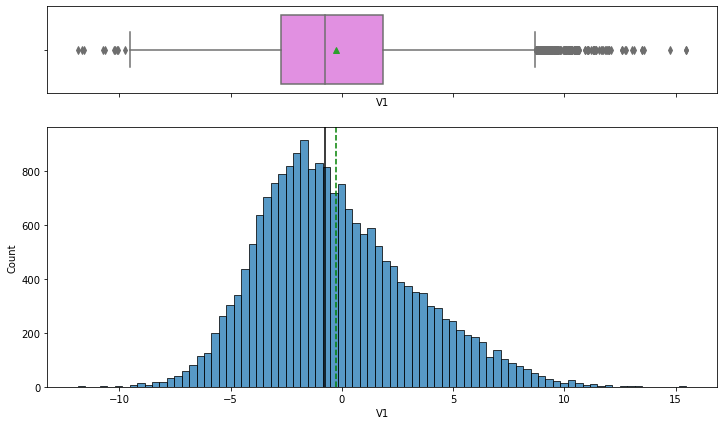

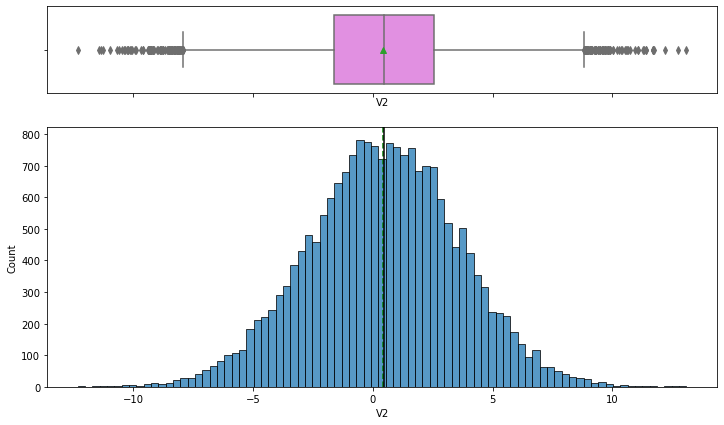

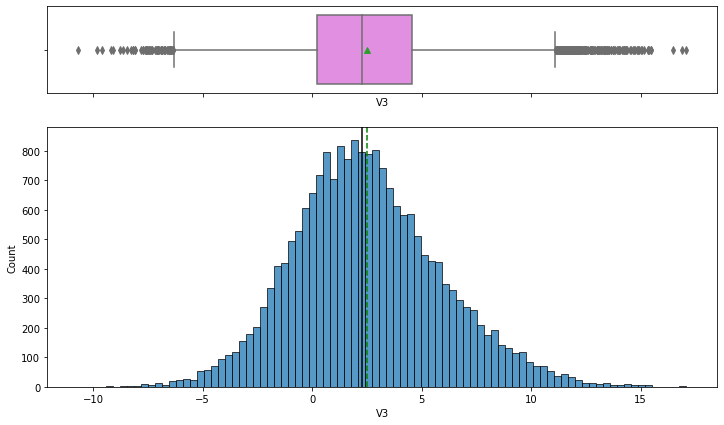

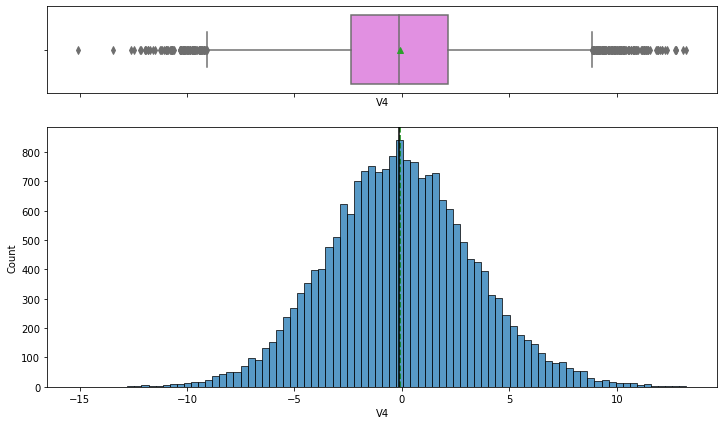

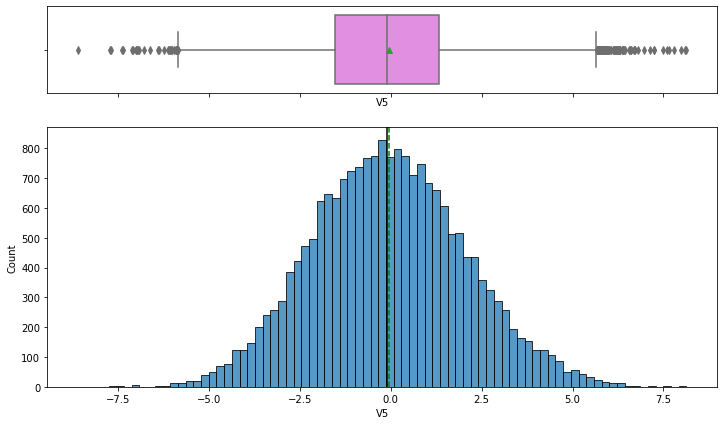

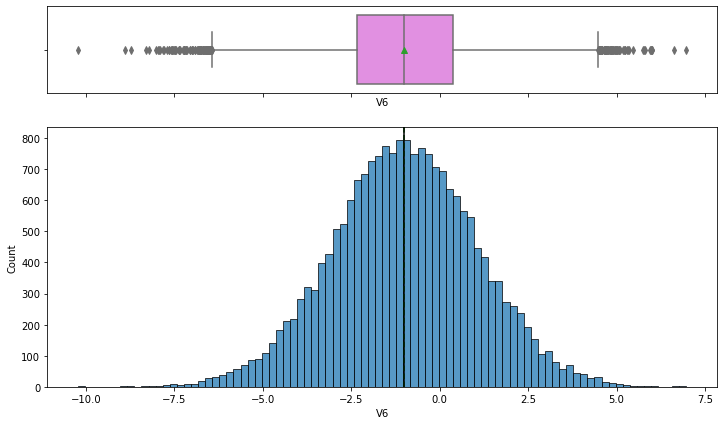

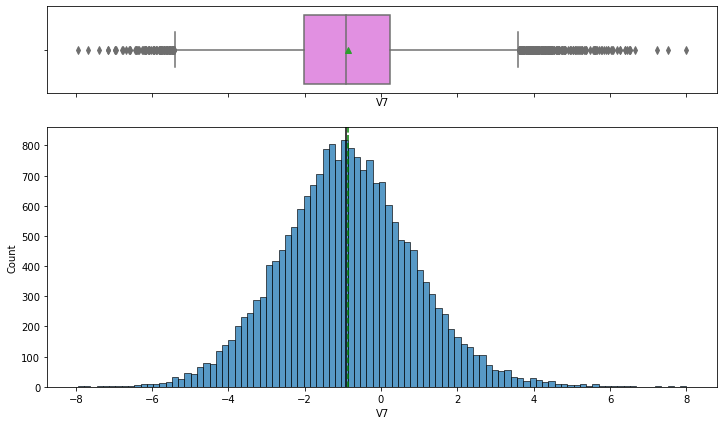

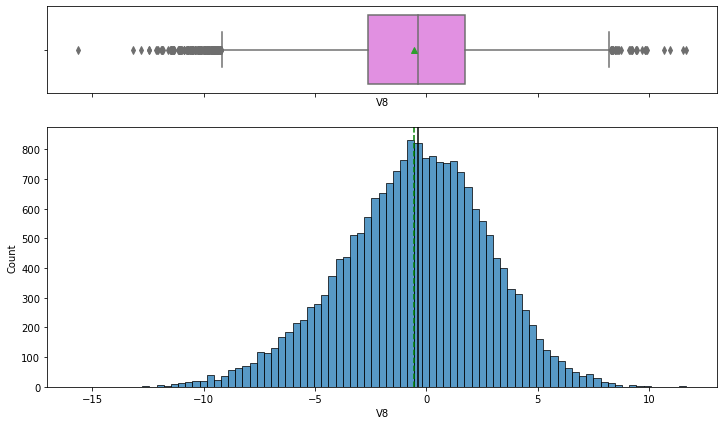

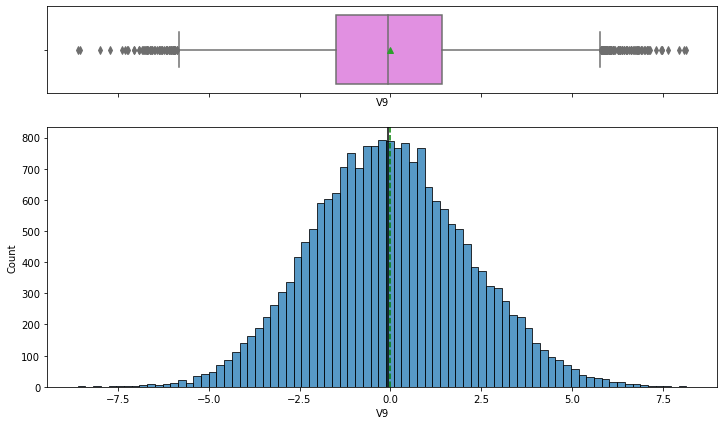

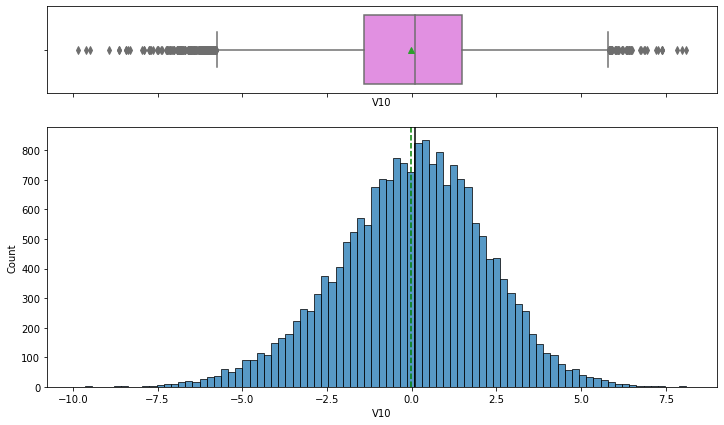

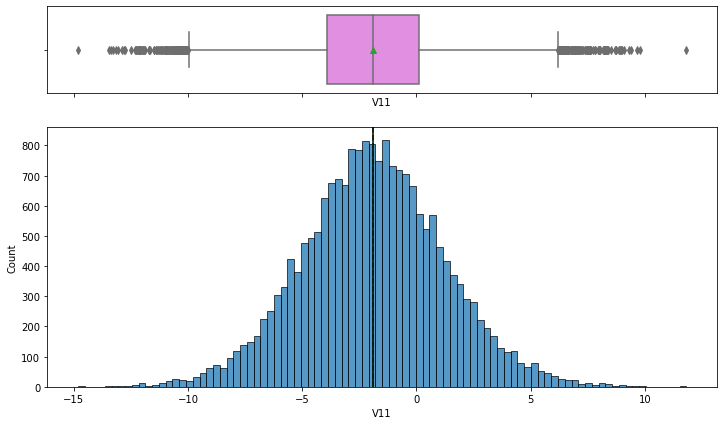

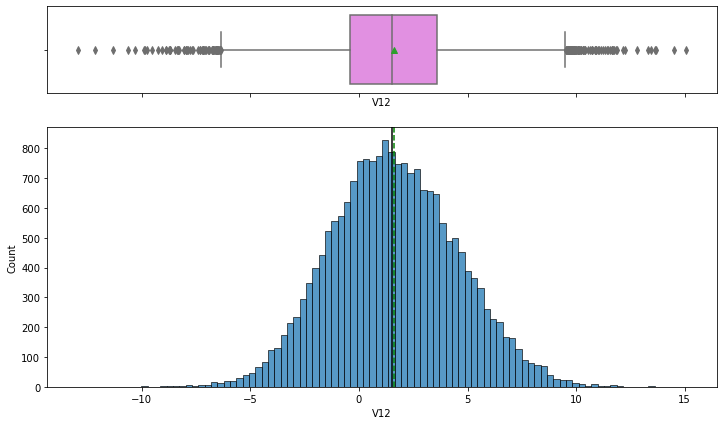

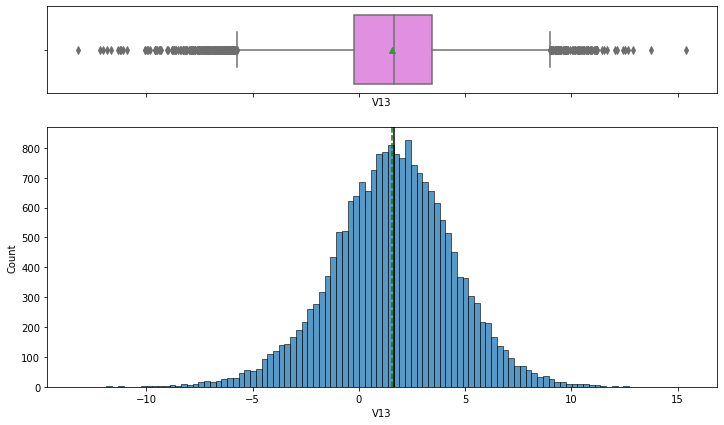

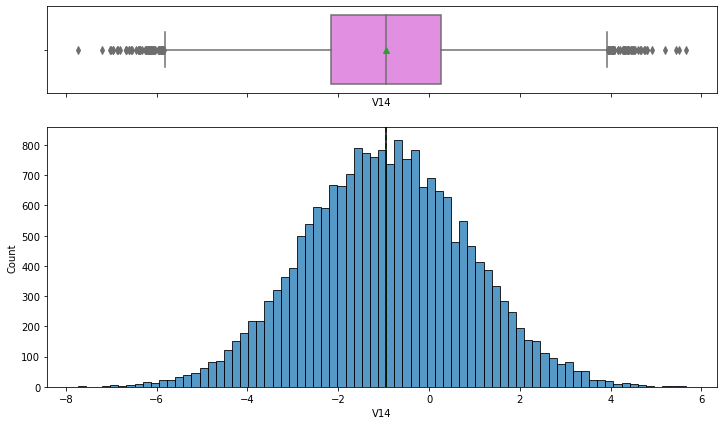

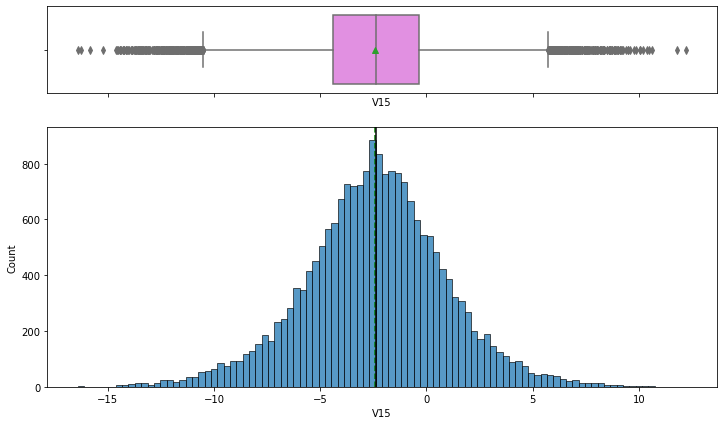

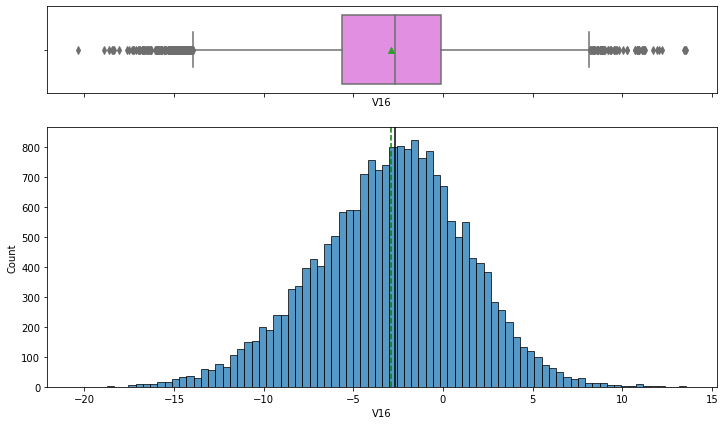

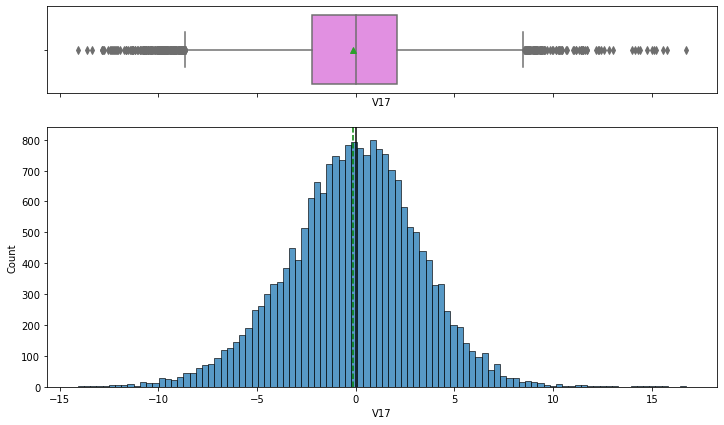

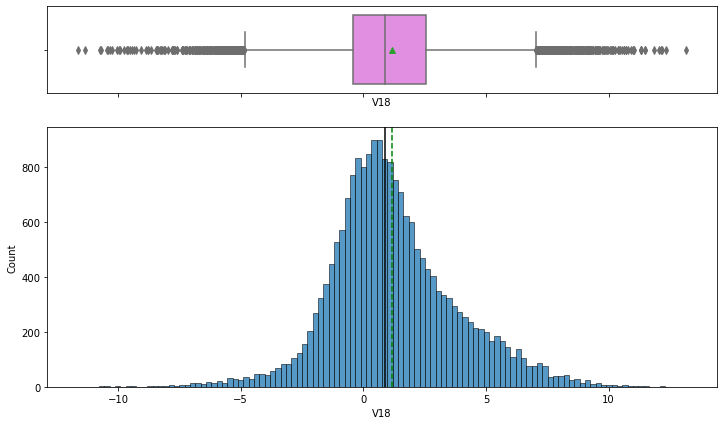

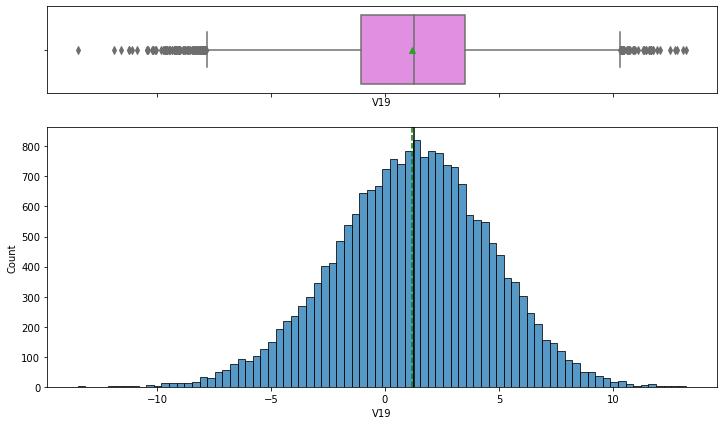

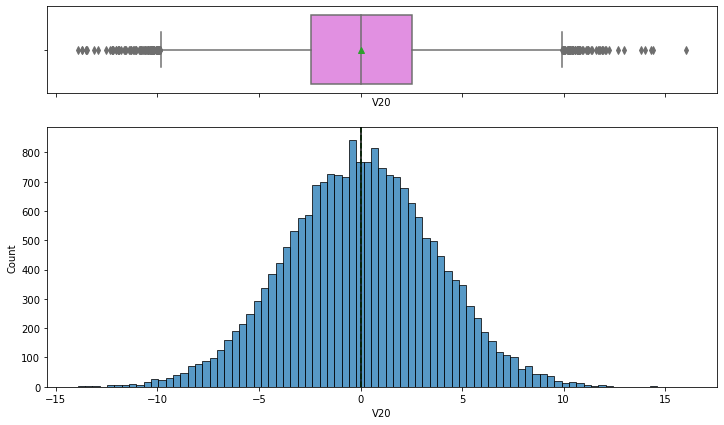

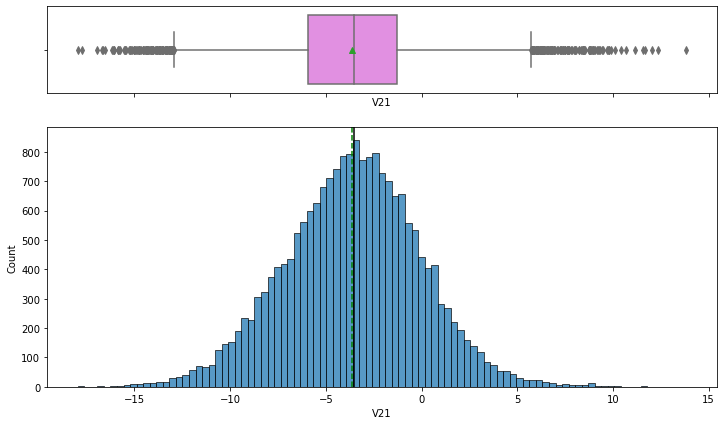

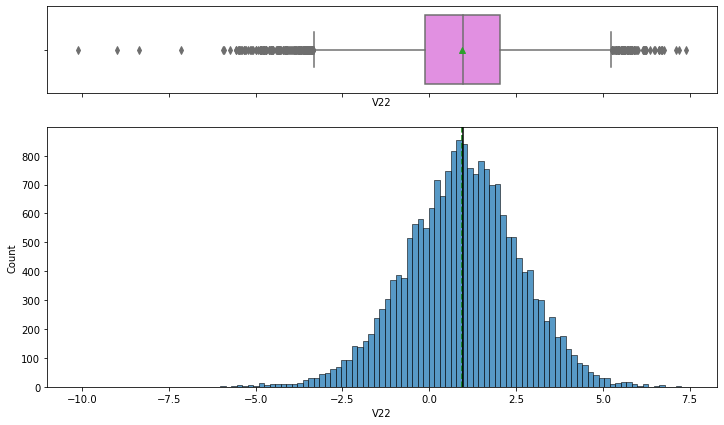

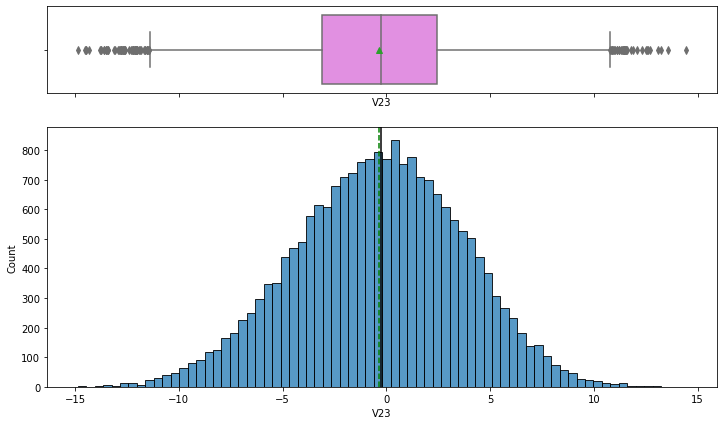

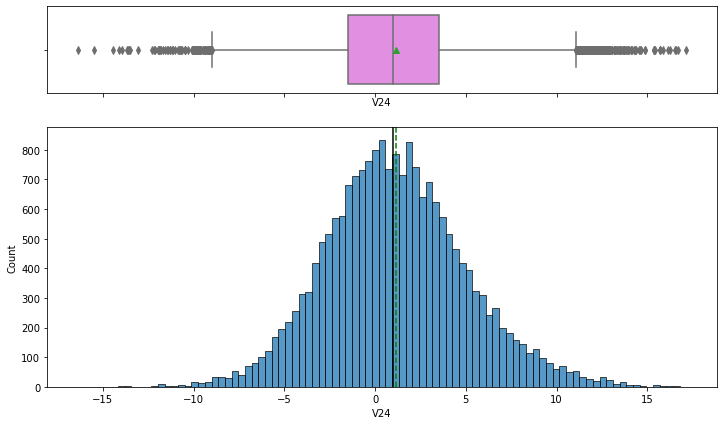

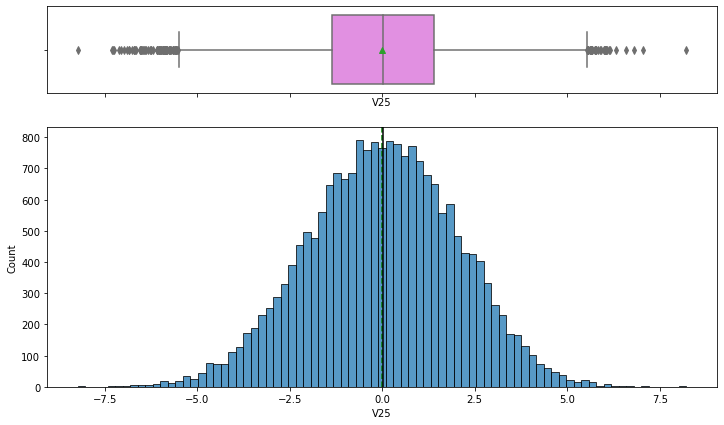

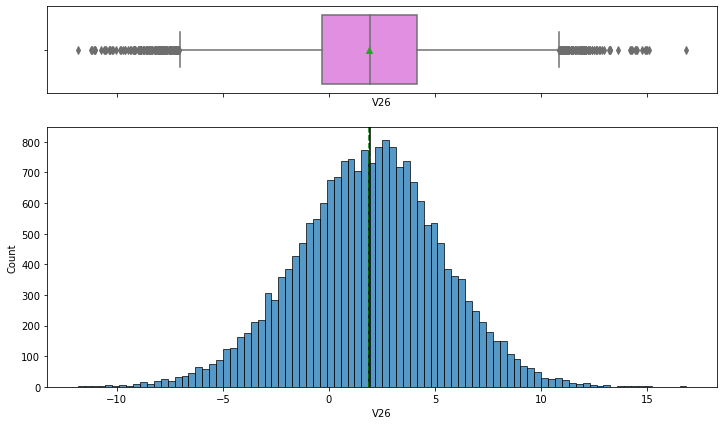

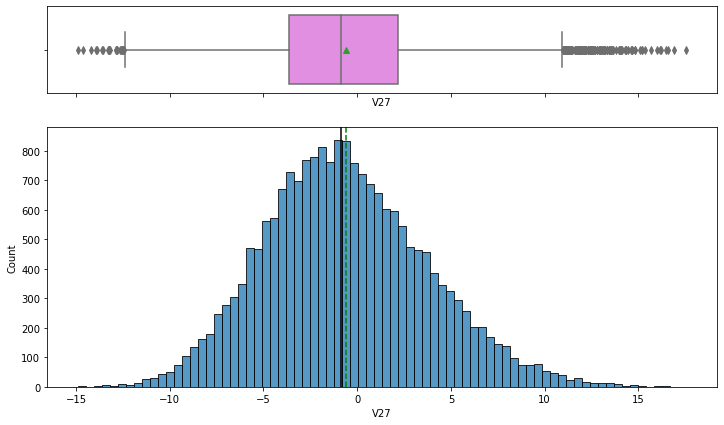

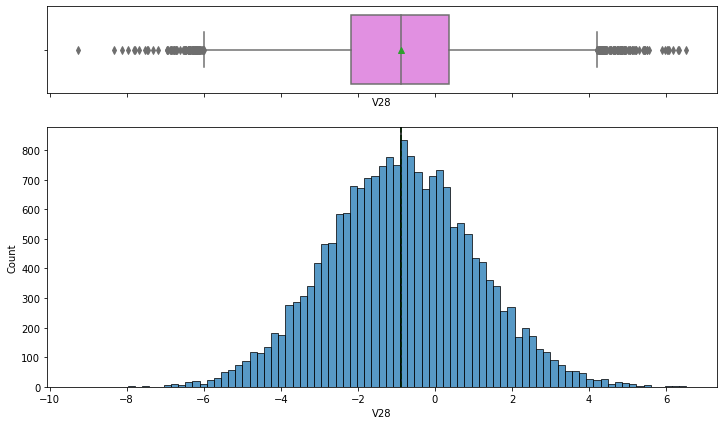

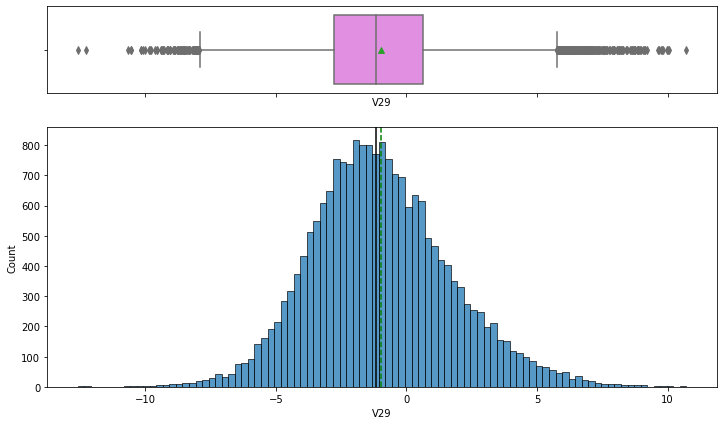

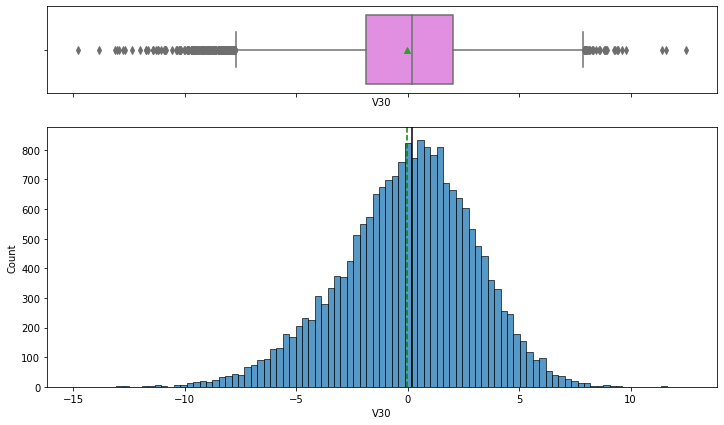

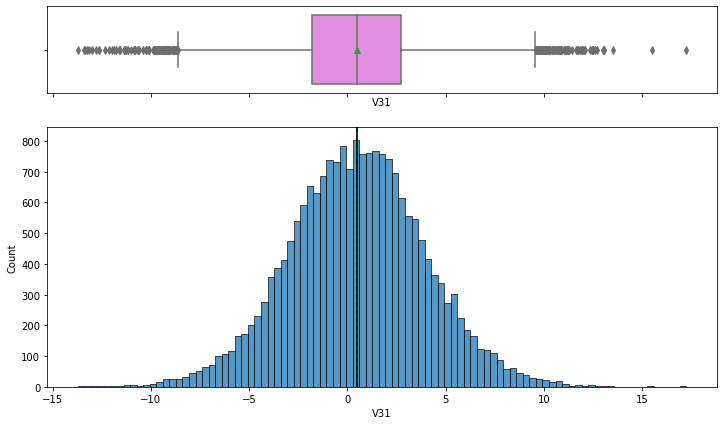

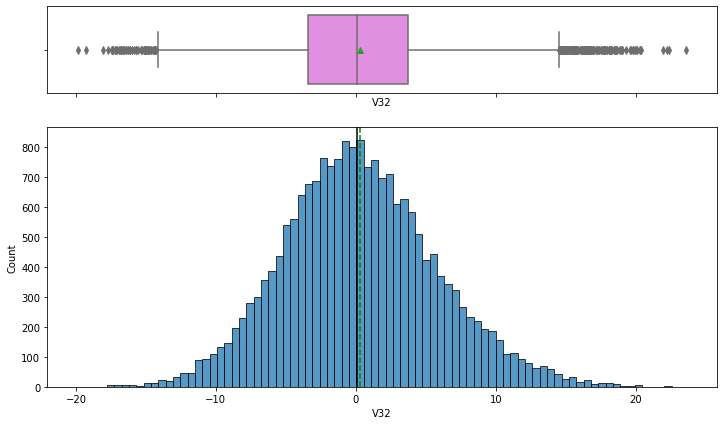

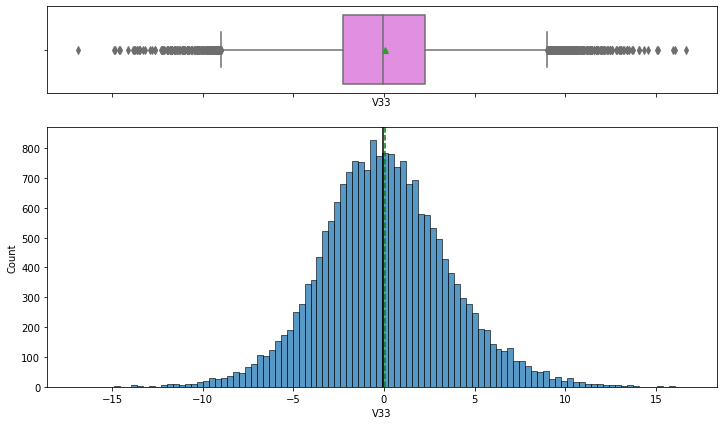

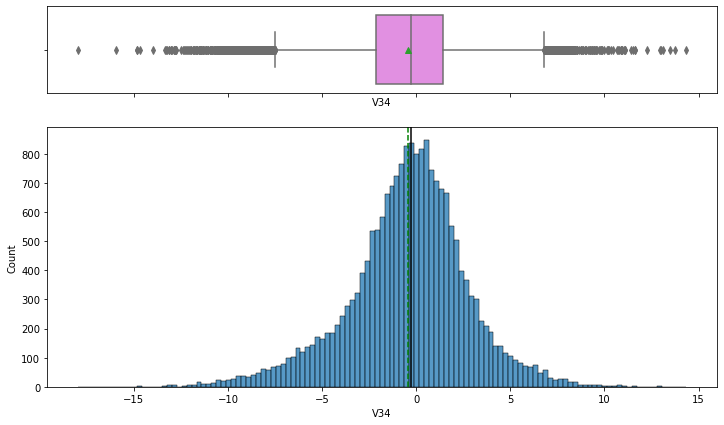

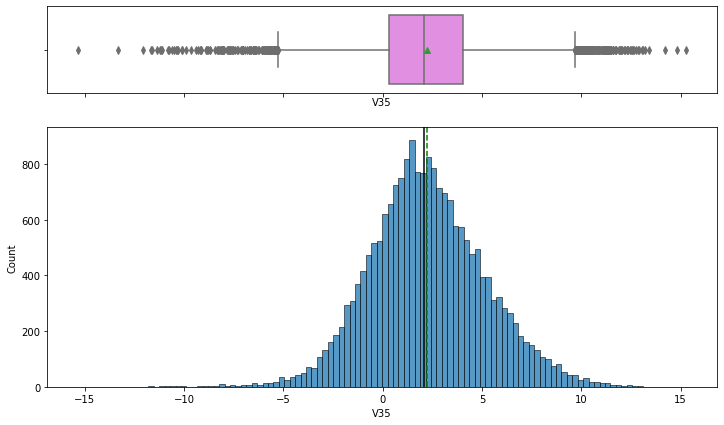

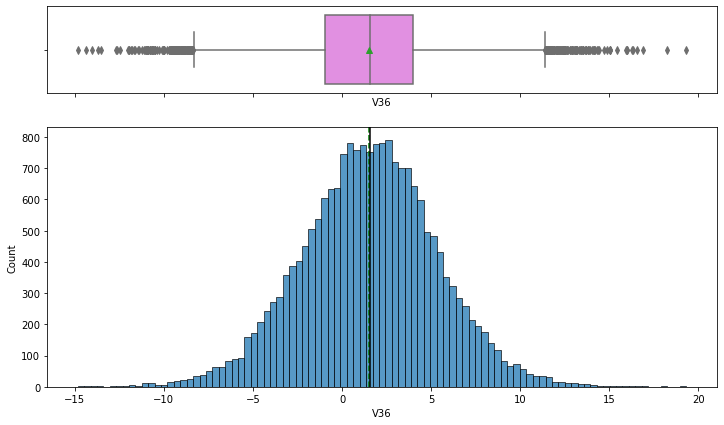

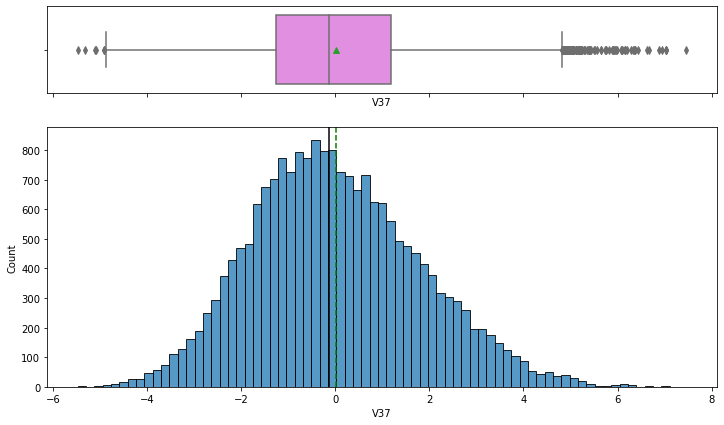

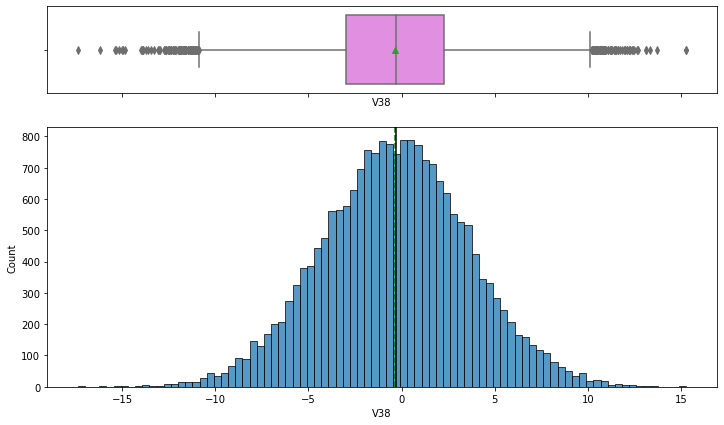

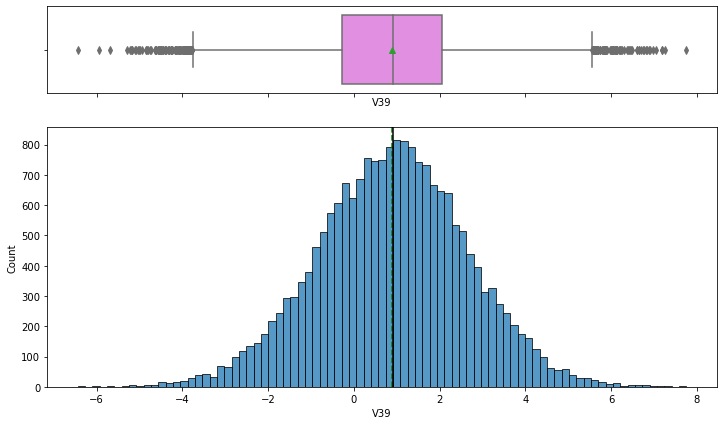

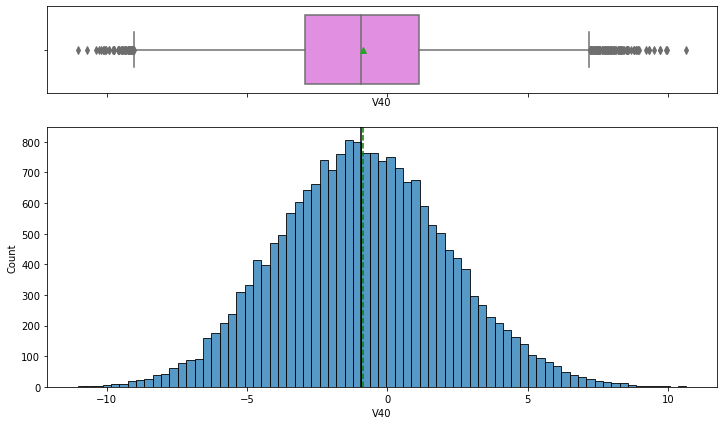

In [21]:
for feature in df.describe(include=np.number).columns:
    histogram_boxplot(df, feature, figsize=(12, 7), kde=False, bins=None) ## Please change the dataframe name as you define while reading the data

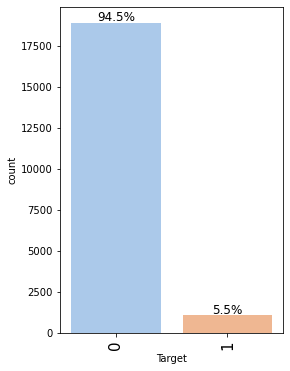

In [22]:
labeled_barplot(df,'Target' ,perc=True, n=None)

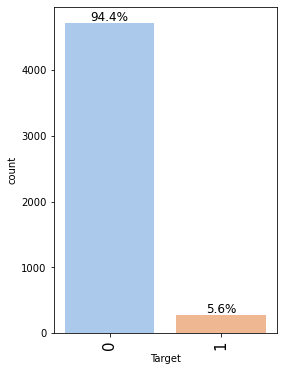

In [23]:
labeled_barplot(df_test,'Target' ,perc=True, n=None)

#### Observations:
- We see that all the numerical variables are very much normally distributed and also a lot of outliers can be seen. Hence we will be imputing the missing values with the median.
- We can see this is a concern of imbalanced data with only 5.6% counts of failure.


## Correlation heatmap

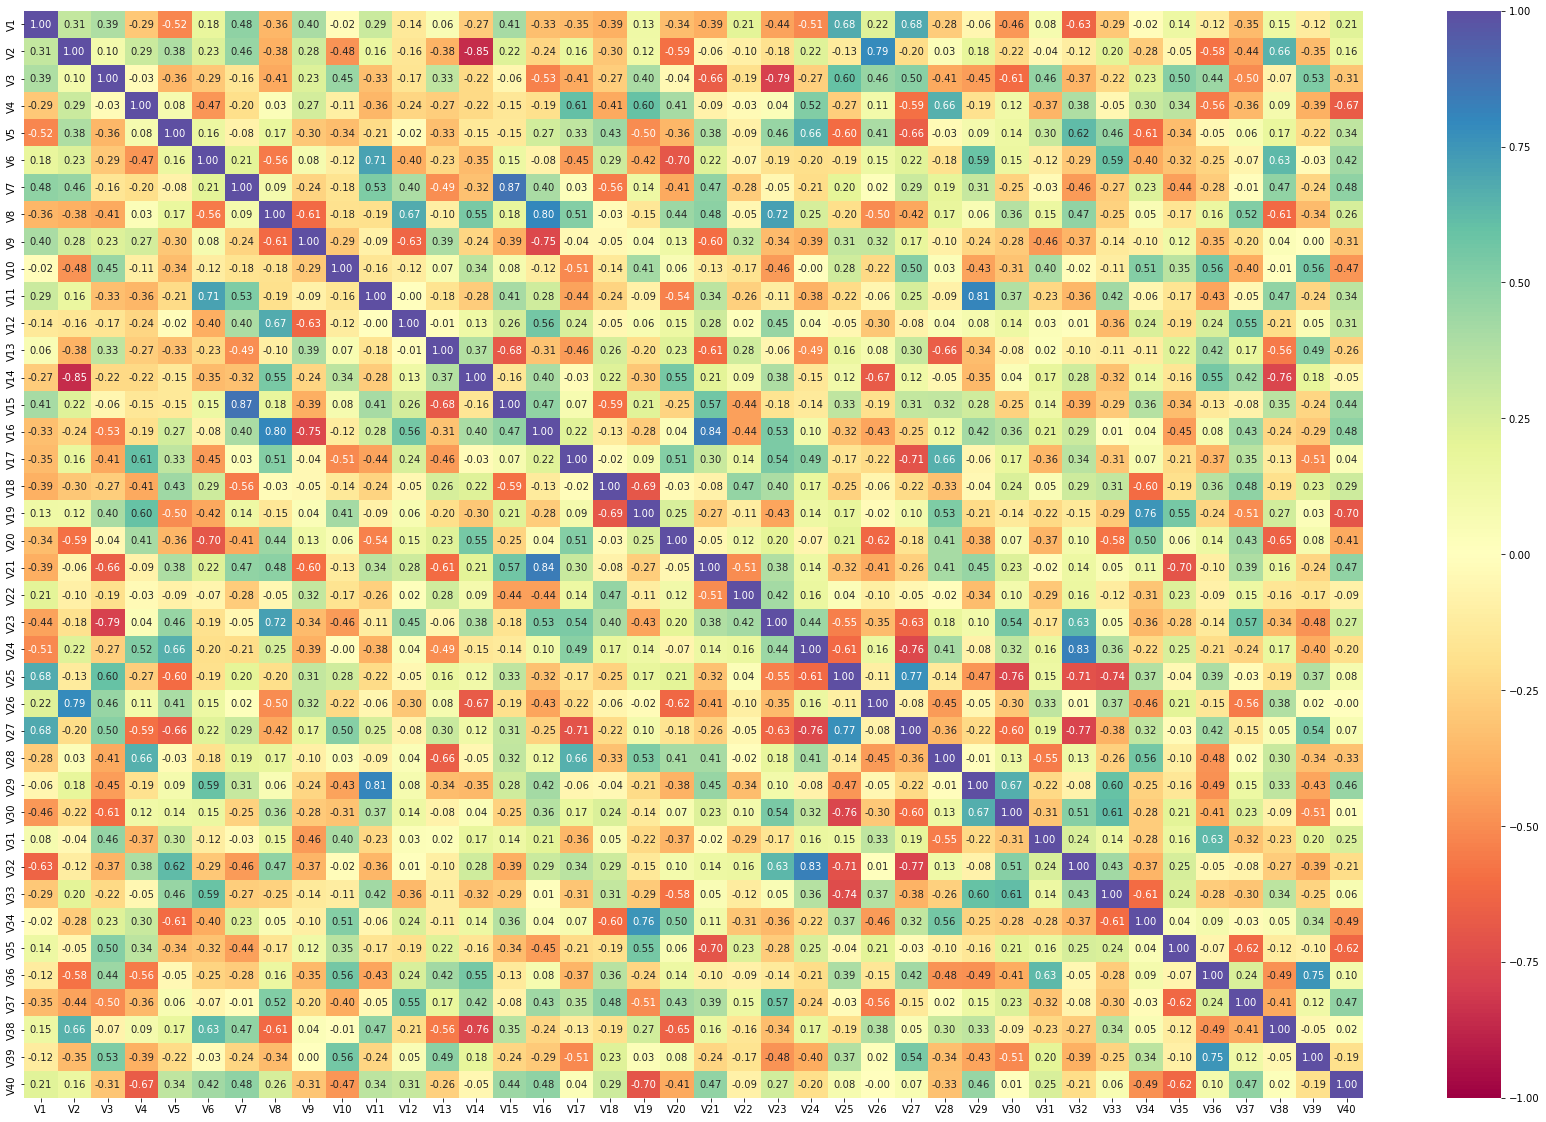

In [24]:
cols_list = df.select_dtypes(include=np.number).columns.tolist()

plt.figure(figsize=(30, 20))
sns.heatmap(
    df[cols_list].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
) ## Complete the code to find the correlation between the variables
plt.show()

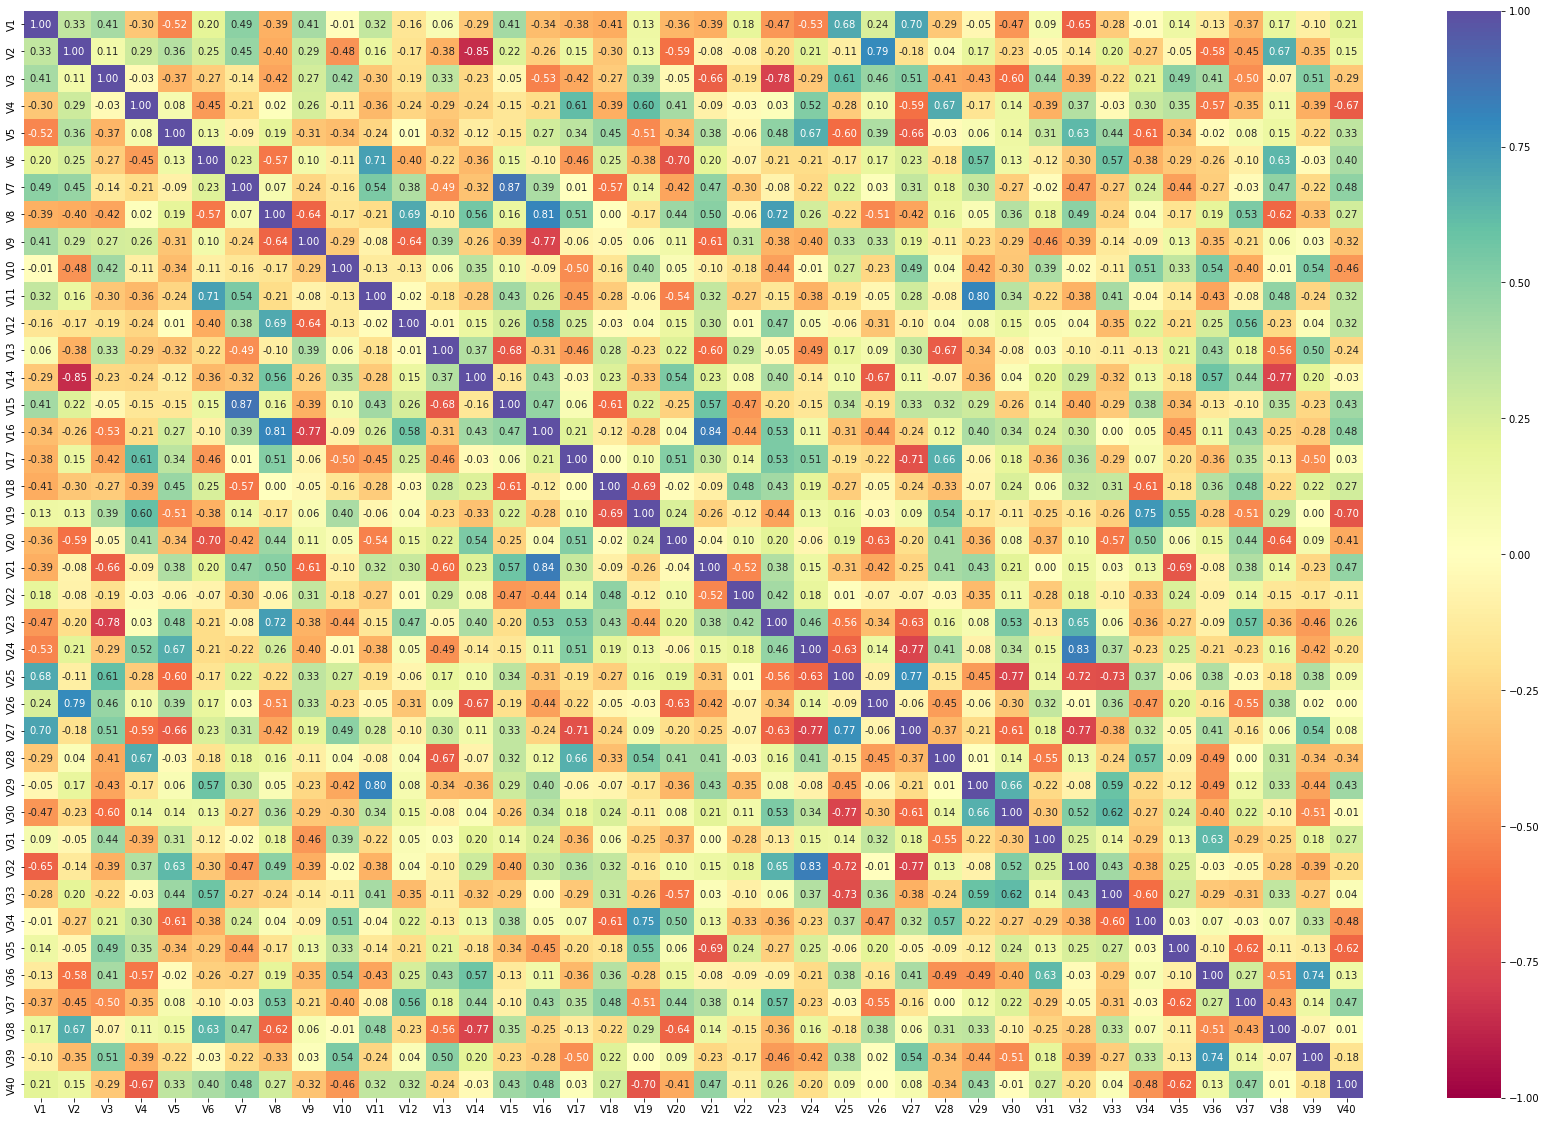

In [25]:
plt.figure(figsize=(30, 20))
sns.heatmap(
    df_test[cols_list].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
) ## Complete the code to find the correlation between the variables
plt.show()

#### Observations:

- `V7` and `V15` , `V16` and `V21`, `V24` and `V32`, `V11` and `V29`, `V2` and `V26` shows significant high positive correlation.
- `V2` and `V14`, `V3` and `V23`, `V14` and `V38`, `V24` and `V27`, `V25` and `V30`, `V27` and `V32` shows significant high negative correlation.
- Both training and test dataset shows the same correlations.


**Multivariate analysis will be skipped due to time constraint as there are too many variables to plot against, and also the fact that due to confidentiality it is difficult to pick what seems to be interesting to look at.**

## Data Pre-processing

In [26]:
# Dividing train data into X and y 
X = df.drop(["Target"], axis=1)
Y = df["Target"]

In [27]:
# split into train and validation set
X_train, X_val, y_train, y_val = train_test_split(
    X, Y, test_size=0.25, random_state=1, stratify=Y
)

In [28]:
# Dividing train data into X and y 
X_test = df_test.drop(["Target"], axis=1)
y_test = df_test["Target"]

In [29]:
print(X_train.shape, X_val.shape, X_test.shape)

(15000, 40) (5000, 40) (5000, 40)


### Outliers Treatment

- Because of the lack of information due to confidentiality, there will be no outlier treatments. So, data given will be treated as actual values.

## Missing value imputation




In [30]:
# imputing the missing values using the mean value
imp_mode = SimpleImputer(strategy="median")

cols_to_impute = ["V1", "V2"]

# fit and transform the imputer on train data
X_train[cols_to_impute] = imp_mode.fit_transform(X_train[cols_to_impute])

# Transform on validation and test data
X_val[cols_to_impute] = imp_mode.transform(X_val[cols_to_impute])

# fit and transform the imputer on test data
X_test[cols_to_impute] = imp_mode.transform(X_test[cols_to_impute])

In [31]:
# Checking that no column has missing values in train or test sets
print(X_train.isna().sum())
print("-" * 30)
print(X_val.isna().sum())
print("-" * 30)
print(X_test.isna().sum())

V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
V31    0
V32    0
V33    0
V34    0
V35    0
V36    0
V37    0
V38    0
V39    0
V40    0
dtype: int64
------------------------------
V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
V31    0
V32    0
V33    0
V34    0
V35    0
V36    0
V37    0
V38    0
V39    0
V40    0
dtype: int64
------------------------------
V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22

- All missing values has been treated, we move on to model building.

## Model Building

### Model evaluation criterion

The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model.
- False negatives (FN) are real failures in a generator where there is no detection by model. 
- False positives (FP) are failure detections in a generator where there is no failure.

**Which metric to optimize?**

* We need to choose the metric which will ensure that the maximum number of generator failures are predicted correctly by the model.
* We would want Recall to be maximized as greater the Recall, the higher the chances of minimizing false negatives.
* We want to minimize false negatives because if a model predicts that a machine will have no failure when there will be a failure, it will increase the maintenance cost.

**Let's define a function to output different metrics (including recall) on the train and test set and a function to show confusion matrix so that we do not have to use the same code repetitively while evaluating models.**

In [32]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1
            
        },
        index=[0],
    )

    return df_perf

In [33]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

### Defining scorer to be used for cross-validation and hyperparameter tuning

In [34]:
# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

### Model Building with original data

In [35]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("dtree", DecisionTreeClassifier(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))

results1 = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models
scores1 = []

# loop through all models to get the mean cross validated score
print("\n" "Default models cross-validation performance on training dataset:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scorer, cv=kfold
    )
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Default models validation performance:" "\n")

for name, model in models:
    model.fit(X_train, y_train)
    scores = recall_score(y_val, model.predict(X_val))
    scores1.append(scores)
    print("{}: {}".format(name, scores))


Default models cross-validation performance on training dataset:

dtree: 0.6982829521679532
Bagging: 0.7210807301060529
Random forest: 0.7235192266070268
GBM: 0.7066661857008874
Adaboost: 0.6309140754635308
Xgboost: 0.7956208065796118

Default models validation performance:

dtree: 0.7050359712230215
Bagging: 0.7302158273381295
Random forest: 0.7266187050359713
GBM: 0.7230215827338129
Adaboost: 0.6762589928057554
Xgboost: 0.8201438848920863


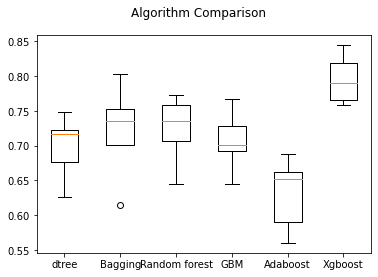

In [36]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure()

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results1)
ax.set_xticklabels(names)

plt.show()

### Model Building with Oversampled data


In [37]:
sm = SMOTE(
    sampling_strategy=1, k_neighbors=5, random_state=1
)  # Synthetic Minority Over Sampling Technique
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)

In [38]:
print("Before UpSampling, counts of label 'Yes': {}".format(sum(y_train == 1)))
print("Before UpSampling, counts of label 'No': {} \n".format(sum(y_train == 0)))


print("After UpSampling, counts of label 'Yes': {}".format(sum(y_train_over == 1)))
print("After UpSampling, counts of label 'No': {} \n".format(sum(y_train_over == 0)))


print("After UpSampling, the shape of train_X: {}".format(X_train_over.shape))
print("After UpSampling, the shape of train_y: {} \n".format(y_train_over.shape))

Before UpSampling, counts of label 'Yes': 832
Before UpSampling, counts of label 'No': 14168 

After UpSampling, counts of label 'Yes': 14168
After UpSampling, counts of label 'No': 14168 

After UpSampling, the shape of train_X: (28336, 40)
After UpSampling, the shape of train_y: (28336,) 



In [39]:
%%time
results2 = []  # Empty list to store all model's CV scores
scores2 = []
# loop through all models to get the mean cross validated score
print("\n" "Oversampled models cross-validation performance on training dataset:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_over, y=y_train_over, scoring=scorer, cv=kfold
    )
    results2.append(cv_result)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Oversampled models validation performance:" "\n")

for name, model in models:
    model.fit(X_train_over, y_train_over)
    scores = recall_score(y_val, model.predict(X_val))
    scores2.append(scores)
    print("{}: {}".format(name, scores))


Oversampled models cross-validation performance on training dataset:

dtree: 0.9720494245534969
Bagging: 0.9762141471581656
Random forest: 0.9839075260047615
GBM: 0.9256068151319724
Adaboost: 0.8978689011775473
Xgboost: 0.989554053559209

Oversampled models validation performance:

dtree: 0.7769784172661871
Bagging: 0.8345323741007195
Random forest: 0.8489208633093526
GBM: 0.8776978417266187
Adaboost: 0.8561151079136691
Xgboost: 0.8669064748201439
CPU times: total: 7min 12s
Wall time: 4min 51s


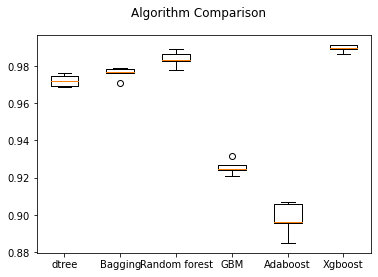

In [40]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure()

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results2)
ax.set_xticklabels(names)

plt.show()

### Model Building with Undersampled data

In [41]:
# Random undersampler for under sampling the data
rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)

In [42]:
print("Before Under Sampling, counts of label 'Yes': {}".format(sum(y_train == 1)))
print("Before Under Sampling, counts of label 'No': {} \n".format(sum(y_train == 0)))

print("After Under Sampling, counts of label 'Yes': {}".format(sum(y_train_un == 1)))
print("After Under Sampling, counts of label 'No': {} \n".format(sum(y_train_un == 0)))

print("After Under Sampling, the shape of train_X: {}".format(X_train_un.shape))
print("After Under Sampling, the shape of train_y: {} \n".format(y_train_un.shape))

Before Under Sampling, counts of label 'Yes': 832
Before Under Sampling, counts of label 'No': 14168 

After Under Sampling, counts of label 'Yes': 832
After Under Sampling, counts of label 'No': 832 

After Under Sampling, the shape of train_X: (1664, 40)
After Under Sampling, the shape of train_y: (1664,) 



In [43]:
%%time
results3 = []  # Empty list to store all model's CV scores
scores3 = []
# loop through all models to get the mean cross validated score
print("\n" "Undersampled model cross-validation performance on training dataset:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_un, y=y_train_un, scoring=scorer, cv=kfold
    )
    results3.append(cv_result)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Undersampled model validation performance:" "\n")

for name, model in models:
    model.fit(X_train_un, y_train_un)
    scores = recall_score(y_val, model.predict(X_val))
    scores3.append(scores)
    print("{}: {}".format(name, scores))


Undersampled model cross-validation performance on training dataset:

dtree: 0.8617776495202367
Bagging: 0.8641945025611427
Random forest: 0.9038669648654498
GBM: 0.8978572974532861
Adaboost: 0.8666113556020489
Xgboost: 0.9074742082100858

Undersampled model validation performance:

dtree: 0.841726618705036
Bagging: 0.8705035971223022
Random forest: 0.8920863309352518
GBM: 0.8884892086330936
Adaboost: 0.8489208633093526
Xgboost: 0.9028776978417267
CPU times: total: 21.6 s
Wall time: 12.6 s


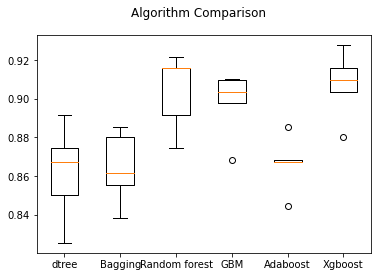

In [44]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure()

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results3)
ax.set_xticklabels(names)

plt.show()

#### Observations:
- In the original dataset, our default XGBoost model performs the best with a recall score of 82%.
- In the oversampled dataset, our decision tree, bagging classifier, random forest and XGBoost model did somewhat well. As there is overfitting issues, we will undergo hyperparameter tuning to check any improvement.
- In the undersampled dataset, our random forest, gradient boosting and XGboost model did well, especially XGBoost with the highest recall score of ~91%. 
- We will tune the above mentioned model with their respective datastes and see if there are any improvements.

## HyperparameterTuning 

### 1) Tuning XGBoost model with original data

***GridSearchCV method***

In [45]:
%%time
# defining model
Model = XGBClassifier(tree_method="gpu_hist",random_state=1,eval_metric='logloss')

# Parameter grid to pass in RandomSearchCV
param_grid={ 'n_estimators': np.arange(250,400,50), 
             'scale_pos_weight': [5,7,10],
             'learning_rate': [0.01,0.02,0.1,0.5], 
             'gamma': [0,3,5,10] ,
             "subsample":[0.5,0.8,1]}

grid = GridSearchCV(estimator=Model, param_grid=param_grid, n_jobs = -1,scoring = 'recall', cv = 5)
grid.fit(X_train, y_train)

print("Best parameters are {} with CV score={}:" .format(grid.best_params_,grid.best_score_))

Best parameters are {'gamma': 10, 'learning_rate': 0.02, 'n_estimators': 350, 'scale_pos_weight': 10, 'subsample': 0.5} with CV score=0.8654426087583869:
CPU times: total: 7.98 s
Wall time: 57min 58s


In [46]:
xgb_tuned_ori = XGBClassifier(
    random_state=1,
    eval_metric="logloss",
    subsample=0.5,
    scale_pos_weight=10,
    n_estimators=350,
    learning_rate=0.02,
    gamma=10,
)

xgb_tuned_ori.fit(X_train,y_train) 

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', gamma=10, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.02, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=350, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=1, reg_alpha=0, reg_lambda=1, ...)

In [47]:
xgb_tuned_ori_train_perf =  model_performance_classification_sklearn(
    xgb_tuned_ori, X_train, y_train
)
xgb_tuned_ori_train_perf

,Accuracy,Recall,Precision,F1
0,0.996267,0.978365,0.955399,0.966746


In [48]:
xgb_tuned_ori_val_perf =  model_performance_classification_sklearn(
    xgb_tuned_ori, X_val, y_val
)
xgb_tuned_ori_val_perf

,Accuracy,Recall,Precision,F1
0,0.9866,0.859712,0.895131,0.877064


***RandomSearchCV method***

In [49]:
%%time
# defining model
Model = XGBClassifier(random_state=1,eval_metric='logloss')

# Parameter grid to pass in RandomSearchCV
param_grid={ 'n_estimators': [300,350,400], 
             'scale_pos_weight': [5,8,10], 
             'learning_rate': [0.01,0.02,0.05], 
             'gamma': [15,25,30], 
             "subsample":[0.3,0.5,0.7],}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.3, 'scale_pos_weight': 10, 'n_estimators': 400, 'learning_rate': 0.05, 'gamma': 30} with CV score=0.8702546713801314:
CPU times: total: 35 s
Wall time: 9min 21s


In [50]:
xgb_tuned_random_ori = XGBClassifier(
    random_state=1,
    eval_metric="logloss",
    subsample=0.3,
    scale_pos_weight=10,
    n_estimators=400,
    learning_rate=0.05,
    gamma=30,
)

xgb_tuned_random_ori.fit(X_train,y_train) 

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', gamma=30, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=400, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=1, reg_alpha=0, reg_lambda=1, ...)

In [51]:
xgb_tuned_random_ori_train_perf =  model_performance_classification_sklearn(
    xgb_tuned_random_ori, X_train, y_train
)
xgb_tuned_random_ori_train_perf

,Accuracy,Recall,Precision,F1
0,0.990467,0.949519,0.886644,0.917005


In [52]:
xgb_tuned_random_ori_val_perf =  model_performance_classification_sklearn(
    xgb_tuned_random_ori, X_val, y_val
)
xgb_tuned_random_ori_val_perf

,Accuracy,Recall,Precision,F1
0,0.9836,0.870504,0.840278,0.855124


### 2) Tuning decision tree model with oversampled data

***GridSearchCV method***

In [53]:
%%time
# defining model
Model = DecisionTreeClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {'max_depth': np.arange(2,6),
              'min_samples_leaf': [5, 7, 10],
              'max_leaf_nodes' : [10,13,15],
              'min_impurity_decrease': [0.0001,0.001] }

grid = GridSearchCV(estimator=Model, param_grid=param_grid, n_jobs = -1,scoring = 'recall', cv = 5)
grid.fit(X_train_over, y_train_over)

print("Best parameters are {} with CV score={}:" .format(grid.best_params_,grid.best_score_))

Best parameters are {'max_depth': 3, 'max_leaf_nodes': 10, 'min_impurity_decrease': 0.0001, 'min_samples_leaf': 5} with CV score=0.9102913265648006:
CPU times: total: 1.67 s
Wall time: 12.1 s


In [54]:
dt_tuned_over = DecisionTreeClassifier(
    random_state=1,
    max_depth=3,
    min_samples_leaf=5,
    max_leaf_nodes=10,
    min_impurity_decrease=0.0001,
)

dt_tuned_over.fit(X_train_over,y_train_over) 

DecisionTreeClassifier(max_depth=3, max_leaf_nodes=10,
                       min_impurity_decrease=0.0001, min_samples_leaf=5,
                       random_state=1)

In [55]:
dt_tuned_over_train_perf =  model_performance_classification_sklearn(
    dt_tuned_over, X_train_over, y_train_over
)
dt_tuned_over_train_perf

,Accuracy,Recall,Precision,F1
0,0.843168,0.917349,0.798832,0.853998


In [56]:
dt_tuned_over_val_perf =  model_performance_classification_sklearn(
    dt_tuned_over, X_val, y_val
)
dt_tuned_over_val_perf

,Accuracy,Recall,Precision,F1
0,0.7632,0.884892,0.175966,0.293556


***RandomSearchCV method***

In [57]:
%%time
# defining model
Model = DecisionTreeClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {'max_depth': [2,3,4],
              'min_samples_leaf': [3,5,7],
              'max_leaf_nodes' : [8,10,12],
              'min_impurity_decrease': [0.0001,0.001,0.01] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'min_samples_leaf': 7, 'min_impurity_decrease': 0.01, 'max_leaf_nodes': 12, 'max_depth': 3} with CV score=0.9114911688311041:
CPU times: total: 703 ms
Wall time: 7.96 s


In [126]:
dt_tuned_random_over = DecisionTreeClassifier(
    random_state=1,
    max_depth=3,
    min_samples_leaf=7,
    max_leaf_nodes=12,
    min_impurity_decrease=0.01,
)

dt_tuned_random_over.fit(X_train_over,y_train_over) 

DecisionTreeClassifier(max_depth=3, max_leaf_nodes=12,
                       min_impurity_decrease=0.01, min_samples_leaf=7,
                       random_state=1)

In [127]:
dt_tuned_random_over_train_perf =  model_performance_classification_sklearn(
    dt_tuned_random_over, X_train_over, y_train_over
)
dt_tuned_random_over_train_perf

,Accuracy,Recall,Precision,F1
0,0.837486,0.918055,0.790651,0.849603


In [128]:
dt_tuned_random_over_val_perf =  model_performance_classification_sklearn(
    dt_tuned_random_over, X_val, y_val
)
dt_tuned_random_over_val_perf

,Accuracy,Recall,Precision,F1
0,0.7506,0.895683,0.169734,0.285387


### 3) Tuning bagging model with oversampled data

***GridSearchCV method***

In [61]:
%%time
# defining model
Model = BaggingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {'max_samples': [0.8,0.9,1], 
              'n_estimators':[30,50,70],
              'max_features': [0.7,0.8,0.9] }

grid = GridSearchCV(estimator=Model, param_grid=param_grid, n_jobs = -1,scoring = 'recall', cv = 5)
grid.fit(X_train_over, y_train_over)

print("Best parameters are {} with CV score={}:" .format(grid.best_params_,grid.best_score_))

Best parameters are {'max_features': 0.8, 'max_samples': 0.9, 'n_estimators': 70} with CV score=0.9828488269988673:
CPU times: total: 43.1 s
Wall time: 4min 43s


In [62]:
bag_tuned_over = BaggingClassifier(
    random_state=1,
    max_samples=0.9,
    max_features=0.8,
    n_estimators=70,
)

bag_tuned_over.fit(X_train_over,y_train_over) 

BaggingClassifier(max_features=0.8, max_samples=0.9, n_estimators=70,
                  random_state=1)

In [63]:
bag_tuned_over_train_perf =  model_performance_classification_sklearn(
    bag_tuned_over, X_train_over, y_train_over
)
bag_tuned_over_train_perf

,Accuracy,Recall,Precision,F1
0,0.999929,0.999929,0.999929,0.999929


In [64]:
bag_tuned_over_val_perf =  model_performance_classification_sklearn(
    bag_tuned_over, X_val, y_val
)
bag_tuned_over_val_perf

,Accuracy,Recall,Precision,F1
0,0.9862,0.866906,0.882784,0.874773


***RandomSearchCV method***

In [65]:
%%time
# defining model
Model = BaggingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {'max_samples': [0.7,0.8,0.9], 
              'n_estimators':[50,70,90],
              'max_features': [0.7,0.8,0.9] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 90, 'max_samples': 0.9, 'max_features': 0.8} with CV score=0.9830605917106109:
CPU times: total: 55.8 s
Wall time: 8min 42s


In [66]:
bag_tuned_random_over = BaggingClassifier(
    random_state=1,
    max_samples=0.8,
    max_features=0.9,
    n_estimators=90,
)

bag_tuned_random_over.fit(X_train_over,y_train_over) 

BaggingClassifier(max_features=0.9, max_samples=0.8, n_estimators=90,
                  random_state=1)

In [67]:
bag_tuned_random_over_train_perf =  model_performance_classification_sklearn(
    bag_tuned_random_over, X_train_over, y_train_over
)
bag_tuned_random_over_train_perf

,Accuracy,Recall,Precision,F1
0,0.999894,0.999859,0.999929,0.999894


In [68]:
bag_tuned_random_over_val_perf =  model_performance_classification_sklearn(
    bag_tuned_random_over, X_val, y_val
)
bag_tuned_random_over_val_perf

,Accuracy,Recall,Precision,F1
0,0.9838,0.874101,0.84083,0.857143


### 4) Tuning random forest model with oversampled data

***GridSearchCV method***

In [69]:
%%time
# defining model
Model = RandomForestClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { "n_estimators": [200,250,300], 
              "min_samples_leaf": np.arange(1,4), 
              "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'], 
              "max_samples": np.arange(0.4, 0.7, 0.1),
              }

grid = GridSearchCV(estimator=Model, param_grid=param_grid, n_jobs = -1,scoring = 'recall', cv = 5)
grid.fit(X_train_over, y_train_over)

print("Best parameters are {} with CV score={}:" .format(grid.best_params_,grid.best_score_))

Best parameters are {'max_features': 'sqrt', 'max_samples': 0.6, 'min_samples_leaf': 1, 'n_estimators': 200} with CV score=0.9818606498020482:
CPU times: total: 15.3 s
Wall time: 3min 29s


In [70]:
rf_tuned_over = RandomForestClassifier(
    random_state=1,
    max_samples=0.6,
    max_features='sqrt',
    n_estimators=200,
    min_samples_leaf=1,
)

rf_tuned_over.fit(X_train_over,y_train_over) 

RandomForestClassifier(max_samples=0.6, n_estimators=200, random_state=1)

In [71]:
rf_tuned_over_train_perf =  model_performance_classification_sklearn(
    rf_tuned_over, X_train_over, y_train_over
)
rf_tuned_over_train_perf

,Accuracy,Recall,Precision,F1
0,0.999682,0.999435,0.999929,0.999682


In [72]:
rf_tuned_over_val_perf =  model_performance_classification_sklearn(
    rf_tuned_over, X_val, y_val
)
rf_tuned_over_val_perf

,Accuracy,Recall,Precision,F1
0,0.9882,0.863309,0.91954,0.890538


***RandomSearchCV method***

In [73]:
%%time
# defining model
Model = RandomForestClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { "n_estimators": [150,200,250], 
              "min_samples_leaf": [1,2,3], 
              "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'], 
              "max_samples": [0.5,0.6,0.7]
              }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 250, 'min_samples_leaf': 1, 'max_samples': 0.7, 'max_features': 'sqrt'} with CV score=0.9832018097027149:
CPU times: total: 21.9 s
Wall time: 3min 8s


In [74]:
rf_tuned_random_over = RandomForestClassifier(
    random_state=1,
    max_samples=0.7,
    max_features='sqrt',
    n_estimators=250,
    min_samples_leaf=1,
)

rf_tuned_random_over.fit(X_train_over,y_train_over) 

RandomForestClassifier(max_samples=0.7, n_estimators=250, random_state=1)

In [75]:
rf_tuned_random_over_train_perf =  model_performance_classification_sklearn(
    rf_tuned_random_over, X_train_over, y_train_over
)
rf_tuned_random_over_train_perf

,Accuracy,Recall,Precision,F1
0,1.0,1.0,1.0,1.0


In [76]:
rf_tuned_random_over_val_perf =  model_performance_classification_sklearn(
    rf_tuned_random_over, X_val, y_val
)
rf_tuned_random_over_val_perf

,Accuracy,Recall,Precision,F1
0,0.9882,0.852518,0.929412,0.889306


### 5) Tuning XGBoost model with oversampled data

***GridSearchCV method***

In [77]:
%%time
# defining model
Model = XGBClassifier(tree_method="gpu_hist",random_state=1,eval_metric='logloss')

# Parameter grid to pass in RandomSearchCV
param_grid={ 'n_estimators': np.arange(250,400,50), 
             'scale_pos_weight': [5,7,10],
             'learning_rate': [0.01,0.02,0.1,0.5], 
             'gamma': [0,3,5,10] ,
             "subsample":[0.5,0.8,1]}

grid = GridSearchCV(estimator=Model, param_grid=param_grid, n_jobs = -1,scoring = 'recall', cv = 5)
grid.fit(X_train_over, y_train_over)

print("Best parameters are {} with CV score={}:" .format(grid.best_params_,grid.best_score_))

Best parameters are {'gamma': 5, 'learning_rate': 0.1, 'n_estimators': 250, 'scale_pos_weight': 10, 'subsample': 0.8} with CV score=0.9957652039764235:
CPU times: total: 6.92 s
Wall time: 1h 10min 2s


In [78]:
xgb_tuned_over = XGBClassifier(
    random_state=1,
    eval_metric="logloss",
    subsample=0.8,
    scale_pos_weight=10,
    n_estimators=250,
    learning_rate=0.1,
    gamma=5
)

xgb_tuned_over.fit(X_train_over,y_train_over) 

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', gamma=5, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=250, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=1, reg_alpha=0, reg_lambda=1, ...)

In [79]:
xgb_tuned_over_train_perf =  model_performance_classification_sklearn(
    xgb_tuned_over, X_train_over, y_train_over
)
xgb_tuned_over_train_perf

,Accuracy,Recall,Precision,F1
0,0.998059,1.0,0.996133,0.998063


In [80]:
xgb_tuned_over_val_perf =  model_performance_classification_sklearn(
    xgb_tuned_over, X_val, y_val
)
xgb_tuned_over_val_perf

,Accuracy,Recall,Precision,F1
0,0.9778,0.884892,0.756923,0.81592


***RandomSearchCV method***

In [81]:
%%time
# defining model
Model = XGBClassifier(random_state=1,eval_metric='logloss')

# Parameter grid to pass in RandomSearchCV
param_grid={ 'n_estimators': [200,250,300], 
             'scale_pos_weight': [5,7,10],
             'learning_rate': [0.02,0.1,0.5], 
             'gamma': [3,5,10] ,
             "subsample":[0.5,0.8,1]}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.5, 'scale_pos_weight': 10, 'n_estimators': 300, 'learning_rate': 0.1, 'gamma': 5} with CV score=0.9955533645329855:
CPU times: total: 1min 7s
Wall time: 17min 29s


In [129]:
xgb_tuned_random_over = XGBClassifier(
    random_state=1,
    eval_metric="logloss",
    subsample=0.5,
    scale_pos_weight=10,
    n_estimators=300,
    learning_rate=0.1,
    gamma=5,
)

xgb_tuned_random_over.fit(X_train_over,y_train_over) 

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', gamma=5, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=1, reg_alpha=0, reg_lambda=1, ...)

In [130]:
xgb_tuned_random_over_train_perf =  model_performance_classification_sklearn(
    xgb_tuned_random_over, X_train_over, y_train_over
)
xgb_tuned_random_over_train_perf

,Accuracy,Recall,Precision,F1
0,0.997459,1.0,0.994944,0.997466


In [131]:
xgb_tuned_random_over_val_perf =  model_performance_classification_sklearn(
    xgb_tuned_random_over, X_val, y_val
)
xgb_tuned_random_over_val_perf

,Accuracy,Recall,Precision,F1
0,0.9768,0.884892,0.745455,0.809211


### 6) Tuning random forest model with undersampled data

***GridSearchCV method***

In [85]:
%%time
# defining model
Model = RandomForestClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { "n_estimators": [200,250,300], 
              "min_samples_leaf": np.arange(1,4), 
              "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'], 
              "max_samples": np.arange(0.4, 0.7, 0.1),
              }


grid = GridSearchCV(estimator=Model, param_grid=param_grid, n_jobs = -1,scoring = 'recall', cv = 5)
grid.fit(X_train_un, y_train_un)

print("Best parameters are {} with CV score={}:" .format(grid.best_params_,grid.best_score_))

Best parameters are {'max_features': 'sqrt', 'max_samples': 0.5, 'min_samples_leaf': 1, 'n_estimators': 250} with CV score=0.8990188298102592:
CPU times: total: 1.59 s
Wall time: 11.1 s


In [86]:
rf_tuned_un = RandomForestClassifier(
    random_state=1,
    max_samples=0.5,
    max_features='sqrt',
    n_estimators=250,
    min_samples_leaf=1
)

rf_tuned_un.fit(X_train_un,y_train_un) 

RandomForestClassifier(max_samples=0.5, n_estimators=250, random_state=1)

In [87]:
rf_tuned_un_train_perf =  model_performance_classification_sklearn(
    rf_tuned_un, X_train_over, y_train_over
)
rf_tuned_un_train_perf

,Accuracy,Recall,Precision,F1
0,0.940853,0.931748,0.949029,0.940309


In [88]:
rf_tuned_un_val_perf =  model_performance_classification_sklearn(
    rf_tuned_un, X_val, y_val
)
rf_tuned_un_val_perf

,Accuracy,Recall,Precision,F1
0,0.9392,0.884892,0.474903,0.61809


***RandomSearchCV method***

In [89]:
%%time
# defining model
Model = RandomForestClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { "n_estimators": [200,250,300], 
              "min_samples_leaf": [1,2,3], 
              "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'], 
              "max_samples": [0.4,0.5,0.6],
              }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 300, 'min_samples_leaf': 2, 'max_samples': 0.5, 'max_features': 'sqrt'} with CV score=0.8990116153235697:
CPU times: total: 1.16 s
Wall time: 10.2 s


In [132]:
rf_tuned_random_un = RandomForestClassifier(
    random_state=1,
    max_samples=0.5,
    max_features='sqrt',
    n_estimators=300,
    min_samples_leaf=2
)

rf_tuned_random_un.fit(X_train_un,y_train_un) 

RandomForestClassifier(max_samples=0.5, min_samples_leaf=2, n_estimators=300,
                       random_state=1)

In [133]:
rf_tuned_random_un_train_perf =  model_performance_classification_sklearn(
    rf_tuned_random_un, X_train_over, y_train_over
)
rf_tuned_random_un_train_perf

,Accuracy,Recall,Precision,F1
0,0.940782,0.927513,0.952799,0.939986


In [134]:
rf_tuned_random_un_val_perf =  model_performance_classification_sklearn(
    rf_tuned_random_un, X_val, y_val
)
rf_tuned_random_un_val_perf

,Accuracy,Recall,Precision,F1
0,0.9462,0.92446,0.508911,0.65645


### 7) Tuning gradient boost model with undersampled data

***GridSearchCV method***

In [93]:
%%time
# defining model
Model = GradientBoostingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { "n_estimators": np.arange(100,150,25), 
               "learning_rate": [0.05,0.2,1], 
               "subsample":[0.6,0.9,1], 
               "max_features":[0.5,0.7,1],
             }

grid = GridSearchCV(estimator=Model, param_grid=param_grid, n_jobs = -1,scoring = 'recall', cv = 5)
grid.fit(X_train_un, y_train_un)

print("Best parameters are {} with CV score={}:" .format(grid.best_params_,grid.best_score_))

Best parameters are {'learning_rate': 0.2, 'max_features': 0.5, 'n_estimators': 125, 'subsample': 0.6} with CV score=0.9038308924320034:
CPU times: total: 953 ms
Wall time: 12.8 s


In [94]:
gb_tuned_un = GradientBoostingClassifier(
    random_state=1,
    learning_rate=0.2,
    max_features=0.5,
    n_estimators=125,
    subsample=0.6
)

gb_tuned_un.fit(X_train_un,y_train_un) 

GradientBoostingClassifier(learning_rate=0.2, max_features=0.5,
                           n_estimators=125, random_state=1, subsample=0.6)

In [95]:
gb_tuned_un_train_perf =  model_performance_classification_sklearn(
    gb_tuned_un, X_train_over, y_train_over
)
gb_tuned_un_train_perf

,Accuracy,Recall,Precision,F1
0,0.936865,0.940359,0.933833,0.937085


In [96]:
gb_tuned_un_val_perf =  model_performance_classification_sklearn(
    gb_tuned_un, X_val, y_val
)
gb_tuned_un_val_perf

,Accuracy,Recall,Precision,F1
0,0.9214,0.874101,0.404326,0.552901


***RandomSearchCV method***

In [97]:
%%time
# defining model
Model = GradientBoostingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { "n_estimators": [100,125,150], 
               "learning_rate": [0.1,0.2,0.5,1], 
               "subsample":[0.5,0.7,1], 
               "max_features":[0.4,0.5,0.6],
             }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.7, 'n_estimators': 125, 'max_features': 0.5, 'learning_rate': 0.2} with CV score=0.9050212827357333:
CPU times: total: 859 ms
Wall time: 14.2 s


In [135]:
gb_tuned_random_un = GradientBoostingClassifier(
    random_state=1,
    learning_rate=0.2,
    max_features=0.5,
    n_estimators=125,
    subsample=0.7
)

gb_tuned_random_un.fit(X_train_un,y_train_un) 

GradientBoostingClassifier(learning_rate=0.2, max_features=0.5,
                           n_estimators=125, random_state=1, subsample=0.7)

In [136]:
gb_tuned_random_un_train_perf =  model_performance_classification_sklearn(
    gb_tuned_random_un, X_train_over, y_train_over
)
gb_tuned_random_un_train_perf

,Accuracy,Recall,Precision,F1
0,0.942511,0.939018,0.945625,0.94231


In [137]:
gb_tuned_random_un_val_perf =  model_performance_classification_sklearn(
    gb_tuned_random_un, X_val, y_val
)
gb_tuned_random_un_val_perf

,Accuracy,Recall,Precision,F1
0,0.9284,0.97482,0.435691,0.602222


### 8) Tuning XGB model with undersampled data

***GridSearchCV method***

In [101]:
%%time
# defining model
Model = XGBClassifier(tree_method="gpu_hist",random_state=1,eval_metric='logloss')

# Parameter grid to pass in RandomSearchCV
param_grid={ 'n_estimators': np.arange(250,400,50), 
             'scale_pos_weight': [5,7,10],
             'learning_rate': [0.01,0.02,0.1,0.5], 
             'gamma': [0,3,5,10] ,
             "subsample":[0.5,0.8,1]}

grid = GridSearchCV(estimator=Model, param_grid=param_grid, n_jobs = -1,scoring = 'recall', cv = 5)
grid.fit(X_train_un, y_train_un)

print("Best parameters are {} with CV score={}:" .format(grid.best_params_,grid.best_score_))

Best parameters are {'gamma': 10, 'learning_rate': 0.01, 'n_estimators': 250, 'scale_pos_weight': 10, 'subsample': 0.5} with CV score=0.9410792872087151:
CPU times: total: 6.62 s
Wall time: 39min 23s


In [102]:
xgb_tuned_un = XGBClassifier(
    random_state=1,
    eval_metric="logloss",
    subsample=0.5,
    scale_pos_weight=10,
    n_estimators=250,
    learning_rate=0.01,
    gamma=10
)

xgb_tuned_un.fit(X_train_un,y_train_un) 

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', gamma=10, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=250, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=1, reg_alpha=0, reg_lambda=1, ...)

In [103]:
xgb_tuned_un_train_perf =  model_performance_classification_sklearn(
    xgb_tuned_un, X_train_un, y_train_un
)
xgb_tuned_un_train_perf

,Accuracy,Recall,Precision,F1
0,0.901442,0.998798,0.836016,0.910186


In [104]:
xgb_tuned_un_val_perf =  model_performance_classification_sklearn(
    xgb_tuned_un, X_val, y_val
)
xgb_tuned_un_val_perf

,Accuracy,Recall,Precision,F1
0,0.7444,0.931655,0.170619,0.288419


***RandomSearchCV method***

In [105]:
%%time
# defining model
Model = XGBClassifier(random_state=1,eval_metric='logloss')

# Parameter grid to pass in RandomSearchCV
param_grid={ 'n_estimators': [200,250,300], 
             'scale_pos_weight': [5,7,10],
             'learning_rate': [0.01,0.02,0.1], 
             'gamma': [8,10,15] ,
             "subsample":[0.4,0.5,0.7]}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.5, 'scale_pos_weight': 10, 'n_estimators': 250, 'learning_rate': 0.02, 'gamma': 15} with CV score=0.9386696486544983:
CPU times: total: 4.86 s
Wall time: 46.5 s


In [138]:
xgb_tuned_random_un = XGBClassifier(
    random_state=1,
    eval_metric="logloss",
    subsample=0.5,
    scale_pos_weight=10,
    n_estimators=250,
    learning_rate=0.02,
    gamma=15
)

xgb_tuned_random_un.fit(X_train_un,y_train_un) 

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', gamma=15, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.02, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=250, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=1, reg_alpha=0, reg_lambda=1, ...)

In [139]:
xgb_tuned_random_un_train_perf =  model_performance_classification_sklearn(
    xgb_tuned_random_un, X_train_un, y_train_un
)
xgb_tuned_random_un_train_perf

,Accuracy,Recall,Precision,F1
0,0.916216,0.999099,0.857032,0.922629


In [140]:
xgb_tuned_random_un_val_perf =  model_performance_classification_sklearn(
    xgb_tuned_random_un, X_val, y_val
)
xgb_tuned_random_un_val_perf

,Accuracy,Recall,Precision,F1
0,0.7438,0.996403,0.177906,0.301907


## Model performance comparison and choosing the final model

### 1) Default

In [141]:
defaultdfs = [0,0,0,0,0,0]
for i,name in enumerate(names):
    defaultdfs[i] = pd.DataFrame(
        {
        'Original': results1[i].mean(),
        'Oversampled': results2[i].mean(),
        'Undersampled': results3[i].mean()
        },
        index=[name],
    )
    
for i in range(0,6):
    models_train_comp_df = pd.concat(
        [
            defaultdfs[0],
            defaultdfs[1],
            defaultdfs[2],
            defaultdfs[3],
            defaultdfs[4],
            defaultdfs[5],
        ])
    
print("Default model training performance comparison:")
models_train_comp_df

Default model training performance comparison:


,Original,Oversampled,Undersampled
dtree,0.698283,0.972049,0.861778
Bagging,0.721081,0.976214,0.864195
Random forest,0.723519,0.983908,0.903867
GBM,0.706666,0.925607,0.897857
Adaboost,0.630914,0.897869,0.866611
Xgboost,0.795621,0.989554,0.907474


In [142]:
for i,name in enumerate(names):
    defaultdfs[i] = pd.DataFrame(
        {
        'Original': scores1[i].mean(),
        'Oversampled': scores2[i].mean(),
        'Undersampled': scores3[i].mean()
        },
        index=[name],
    )
    
for i in range(0,6):
    models_val_comp_df = pd.concat(
        [
            defaultdfs[0],
            defaultdfs[1],
            defaultdfs[2],
            defaultdfs[3],
            defaultdfs[4],
            defaultdfs[5],
        ])
    
print("Default model validation performance comparison:")
models_val_comp_df

Default model validation performance comparison:


,Original,Oversampled,Undersampled
dtree,0.705036,0.776978,0.841727
Bagging,0.730216,0.834532,0.870504
Random forest,0.726619,0.848921,0.892086
GBM,0.723022,0.877698,0.888489
Adaboost,0.676259,0.856115,0.848921
Xgboost,0.820144,0.866906,0.902878


### 2) GridSearchCV Tuned

In [143]:
# training performance comparison

models_tuned_train_comp_df = pd.concat(
    [
        xgb_tuned_ori_train_perf.T,
        dt_tuned_over_train_perf.T,
        bag_tuned_over_train_perf.T,
        rf_tuned_over_train_perf.T,
        xgb_tuned_over_train_perf.T,
        rf_tuned_un_train_perf.T,
        gb_tuned_un_train_perf.T,
        xgb_tuned_un_train_perf.T,
    ],
    axis=1,
)
models_tuned_train_comp_df.columns = [
    "Xgboost with original data",
    "Decision Tree with oversampled data",
    "Bagging with oversampled data",
    "Random forest with oversampled data",
    "Xgboost with oversampled data",
    "Random forest with undersampled data",
    "Gradient Boosting with undersampled data",
    "Xgboost with undersampled data",
]
print("GridSearchCV tuned training performance comparison:")
models_tuned_train_comp_df

GridSearchCV tuned training performance comparison:


,Xgboost with original data,Decision Tree with oversampled data,Bagging with oversampled data,Random forest with oversampled data,Xgboost with oversampled data,Random forest with undersampled data,Gradient Boosting with undersampled data,Xgboost with undersampled data
Accuracy,0.996267,0.843168,0.999929,0.999682,0.998059,0.940853,0.936865,0.901442
Recall,0.978365,0.917349,0.999929,0.999435,1.000000,0.931748,0.940359,0.998798
Precision,0.955399,0.798832,0.999929,0.999929,0.996133,0.949029,0.933833,0.836016
F1,0.966746,0.853998,0.999929,0.999682,0.998063,0.940309,0.937085,0.910186


In [144]:
# Validation performance comparison

models_tuned_val_comp_df = pd.concat(
    [
        xgb_tuned_ori_val_perf.T,
        dt_tuned_over_val_perf.T,
        bag_tuned_over_val_perf.T,
        rf_tuned_over_val_perf.T,
        xgb_tuned_over_val_perf.T,
        rf_tuned_un_val_perf.T,
        gb_tuned_un_val_perf.T,
        xgb_tuned_un_val_perf.T,
    ],
    axis=1,
)
models_tuned_val_comp_df.columns = [
    "Xgboost with original data",
    "Decision Tree with oversampled data",
    "Bagging with oversampled data",
    "Random forest with oversampled data",
    "Xgboost with oversampled data",
    "Random forest with undersampled data",
    "Gradient Boosting with undersampled data",
    "Xgboost with undersampled data",
]
print("GridSearchCV tuned validation performance comparison:")
models_tuned_val_comp_df

GridSearchCV tuned validation performance comparison:


,Xgboost with original data,Decision Tree with oversampled data,Bagging with oversampled data,Random forest with oversampled data,Xgboost with oversampled data,Random forest with undersampled data,Gradient Boosting with undersampled data,Xgboost with undersampled data
Accuracy,0.986600,0.763200,0.986200,0.988200,0.977800,0.939200,0.921400,0.744400
Recall,0.859712,0.884892,0.866906,0.863309,0.884892,0.884892,0.874101,0.931655
Precision,0.895131,0.175966,0.882784,0.919540,0.756923,0.474903,0.404326,0.170619
F1,0.877064,0.293556,0.874773,0.890538,0.815920,0.618090,0.552901,0.288419


### 3) RandomSearchCV Tuned

In [145]:
# training performance comparison

models_tuned_random_train_comp_df = pd.concat(
    [
        xgb_tuned_random_ori_train_perf.T,
        dt_tuned_random_over_train_perf.T,
        bag_tuned_random_over_train_perf.T,
        rf_tuned_random_over_train_perf.T,
        xgb_tuned_random_over_train_perf.T,
        rf_tuned_random_un_train_perf.T,
        gb_tuned_random_un_train_perf.T,
        xgb_tuned_random_un_train_perf.T,
    ],
    axis=1,
)
models_tuned_random_train_comp_df.columns = [
    "Xgboost with original data",
    "Decision Tree with oversampled data",
    "Bagging with oversampled data",
    "Random forest with oversampled data",
    "Xgboost with oversampled data",
    "Random forest with undersampled data",
    "Gradient Boosting with undersampled data",
    "Xgboost with undersampled data",
]
print("RandomSearchCV tuned training performance comparison:")
models_tuned_random_train_comp_df

RandomSearchCV tuned training performance comparison:


,Xgboost with original data,Decision Tree with oversampled data,Bagging with oversampled data,Random forest with oversampled data,Xgboost with oversampled data,Random forest with undersampled data,Gradient Boosting with undersampled data,Xgboost with undersampled data
Accuracy,0.990467,0.837486,0.999894,1.0,0.997459,0.940782,0.942511,0.916216
Recall,0.949519,0.918055,0.999859,1.0,1.000000,0.927513,0.939018,0.999099
Precision,0.886644,0.790651,0.999929,1.0,0.994944,0.952799,0.945625,0.857032
F1,0.917005,0.849603,0.999894,1.0,0.997466,0.939986,0.942310,0.922629


In [146]:
# Validation performance comparison

models_tuned_random_val_comp_df = pd.concat(
    [
        xgb_tuned_random_ori_val_perf.T,
        dt_tuned_random_over_val_perf.T,
        bag_tuned_random_over_val_perf.T,
        rf_tuned_random_over_val_perf.T,
        xgb_tuned_random_over_val_perf.T,
        rf_tuned_random_un_val_perf.T,
        gb_tuned_random_un_val_perf.T,
        xgb_tuned_random_un_val_perf.T,
    ],
    axis=1,
)
models_tuned_random_val_comp_df.columns = [
    "Xgboost with original data",
    "Decision Tree with oversampled data",
    "Bagging with oversampled data",
    "Random forest with oversampled data",
    "Xgboost with oversampled data",
    "Random forest with undersampled data",
    "Gradient Boosting with undersampled data",
    "Xgboost with undersampled data",
]
print("RandomSearchCV tuned validation performance comparison:")
models_tuned_random_val_comp_df

RandomSearchCV tuned validation performance comparison:


,Xgboost with original data,Decision Tree with oversampled data,Bagging with oversampled data,Random forest with oversampled data,Xgboost with oversampled data,Random forest with undersampled data,Gradient Boosting with undersampled data,Xgboost with undersampled data
Accuracy,0.983600,0.750600,0.983800,0.988200,0.976800,0.946200,0.928400,0.743800
Recall,0.870504,0.895683,0.874101,0.852518,0.884892,0.924460,0.974820,0.996403
Precision,0.840278,0.169734,0.840830,0.929412,0.745455,0.508911,0.435691,0.177906
F1,0.855124,0.285387,0.857143,0.889306,0.809211,0.656450,0.602222,0.301907


- Our default XGBoost model with undersampled datas seems to be the best performer and hence will be our final preferred model. 
- Although both gridsearch and randomsearch XGBoost model, both with undersampled data, seems to have better recall score but there is a borderline case of being overfitting.
- Moreover, all the default model apart from XGBoost model (with undersampled data) also performed well in validation, all having a decent recall score of 84% ~ 90%.

In [161]:
# best_model = XGBClassifier(random_state=1, eval_metric="logloss")
# best_model = xgb_tuned_random_un
best_model = rf_tuned_random_un
best_model.fit(X_train_un,y_train_un)

RandomForestClassifier(max_samples=0.5, min_samples_leaf=2, n_estimators=300,
                       random_state=1)

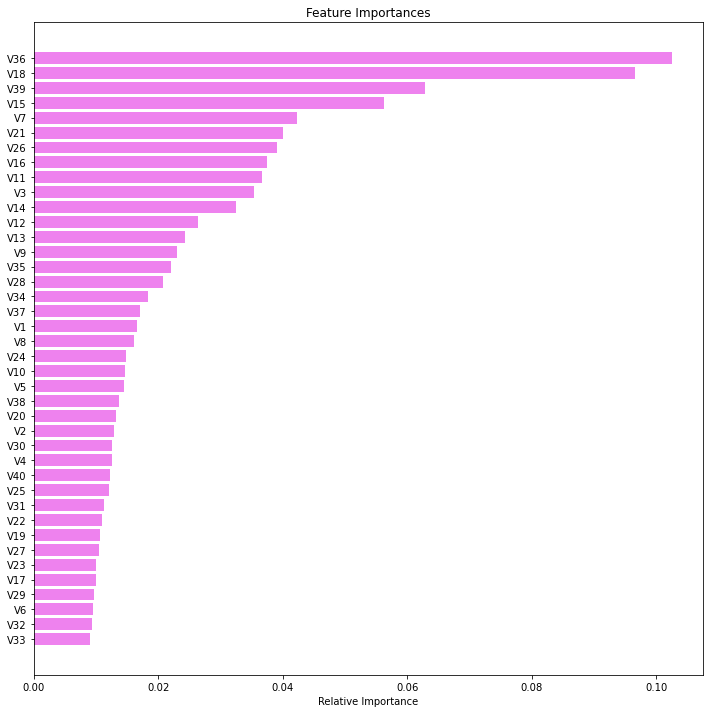

In [162]:
feature_names = X_train.columns
importances = best_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

### Test set final performance

In [163]:
# Calculating different metrics on validation set
best_model_test_perf = model_performance_classification_sklearn(
  best_model  , X_test, y_test
)
print("Test performance:")
best_model_test_perf

Test performance:


,Accuracy,Recall,Precision,F1
0,0.945,0.87234,0.507216,0.64146


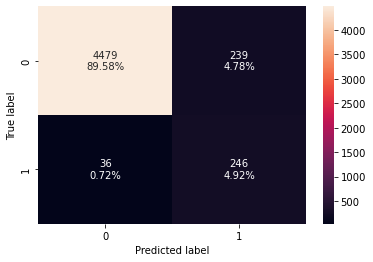

In [164]:
# creating confusion matrix
confusion_matrix_sklearn(best_model, X_test, y_test)

- The test results gives a decent 87% recall score. A very impressive result.
- Variable `V36` and `V18` seems to be the most imporant feature, followed by `V39` and `V15` the top 4's in order.

## Pipelines to build the final model


In [165]:
# Separating target variable and other variables
X_train_pipeline = df.drop(columns="Target")
y_train_pipeline = df["Target"]

# No need of train_test_split since already done
X_test_pipeline = df_test.drop(columns="Target")
y_test_pipeline = df_test["Target"]

In [166]:
# imputing the missing values using the median value
imp_median = SimpleImputer(strategy="median")

# fit and transform the imputer on train data
X_train_pipeline = imp_mode.fit_transform(X_train_pipeline)

In [167]:
# Under Sampling 
rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X_train_un, y_train_un = rus.fit_resample(X_train_pipeline, y_train_pipeline)

In [168]:
# Creating new pipeline with best parameters
pipeline_model = Pipeline(
    steps=[
        ("imp", imp_median),
        (
            "XGB",
#             XGBClassifier(
#                 random_state=1,
#                 eval_metric="logloss",
            RandomForestClassifier(
    random_state=1,
    max_samples=0.5,
    max_features='sqrt',
    n_estimators=300,
    min_samples_leaf=2
),
        ),
    ]
)
# Fit the model on training data
pipeline_model.fit(X_train_un, y_train_un)

Pipeline(steps=[('imp', SimpleImputer(strategy='median')),
                ('XGB',
                 RandomForestClassifier(max_samples=0.5, min_samples_leaf=2,
                                        n_estimators=300, random_state=1))])

In [169]:
# Let's check the performance on test set
Pipeline_model_test = model_performance_classification_sklearn(pipeline_model, X_test_pipeline, y_test_pipeline)
Pipeline_model_test

,Accuracy,Recall,Precision,F1
0,0.945,0.87234,0.507216,0.64146


<AxesSubplot:ylabel='count'>

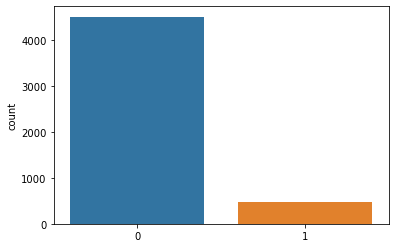

In [170]:
# Let's make some prediction
y_pred = pipeline_model.predict(X_test_pipeline)

sns.countplot(y_pred)

In [160]:
counter = collections.Counter(y_pred)
counter

Counter({0: 3515, 1: 1485})

# Business Insights and Conclusions

- Our analysis boiled down to default XGBoost model with undersampled data, giving a decent recall score of 87% in the test result.
- From our model, in an orderly manner, `V36`, `V18`, `V39` and `V15` are our top 4 important feature. 
- ReneWind should pay attention to the top 4 variables especially for `V36` and `V18` which requires utmost priority for repairs. It can be seen from our feature importances plot, failure of this may lead to a generator replacement.
- Variables other than the top 4 can be inspected frequently since it is not costly to do so.

***